# Confusion matrix. Must have at least 5 trials of each trial type/outcome being comopared in order for animal to contribute to decoding analysis that particular comparison

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_confusion_ALL'

In [ ]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'add_significance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'annotate_heatmap', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'combine_patterns', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'combine_train_test_patterns', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'combine_train_test_patterns_num_trials', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'combine_train_test_patterns_num_trials_speed', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to 

In [ ]:
# use `save_worspace(db)` to save variables at the end
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [6]:
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC

decoder = LinearSVC()

In [7]:
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None, cmap='viridis',
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = pl.gca()

    # Plot the heatmap
    im = ax.imshow(data, cmap, origin="lower", **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=7)
    ax.set_yticklabels(row_labels, fontsize=7)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
    #               labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    pl.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Turn spines off and create white grid.
    #for edge, spine in ax.spines.items():
    #    spine.set_visible(False)

    #ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    #ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    ax.tick_params(axis='both', bottom=False, left=False,pad=0)

    return im#, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["white", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [8]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=15, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    patterns_t={}
    patterns_T={}
    labels_t={}
    labels_T={}
    not_run=[]
    for ani in patterns.keys():
        #only analyze if have > 5 trials of each trial type
        if (np.sum(labels[ani]==classes[0])>=5) and (np.sum(labels[ani]==classes[1])>=5) and (np.sum(labels[ani]==classes[2])>=5): #only include animal if it has x trials of specified trial type
            which_trains = []
            which_tests = []
            #find min number of trials of both trial types, then downsample the type with more trials to match min
            min_trials1=np.sum(labels[ani]==classes[0])
            min_trials2=np.sum(labels[ani]==classes[1])
            min_trials3=np.sum(labels[ani]==classes[2])
            min_trials=min(min_trials1,min_trials2,min_trials3)
            for l in classes:
                if l>=0:                    
                    wt = np.random.permutation(np.where(labels[ani]==l)[0])[:min_trials]
                    if train_test_split<1: #split trials into train and test subsets (ratio set by "train_test_split" value)
                        wT = wt[:int(len(wt)*train_test_split)]
                        which_trains.append(wt[int(len(wt)*train_test_split):])
                        which_tests.append(wT)
                    else:
                        which_trains.append(wt)
            which_train[ani] = np.concatenate(which_trains)
            if train_test_split<1:
                which_test[ani] = np.concatenate(which_tests)
        else:
            not_run.append(ani)
    for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
        #patterns_t[ani] = patterns[ani].copy()
        #labels_t[ani] = labels[ani].copy()
        #print which_train.keys()
    #for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
    #    print ani
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = combine_patterns(patterns_t, labels_t, classes=classes)

        
    if train_test_split<1:
        for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
            #patterns_T[ani] = patterns[ani].copy()
            #labels_T[ani] = labels[ani].copy()
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0],not_run,which_cells)
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None,not_run,which_cells)

def do_test_within(patterns, labels, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    #print "Not run:",not_run
    return decoder.score(xT, yT)

def Not_Run(patterns, labels, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns(patterns, labels, **args)
    return not_run,len(which_cells)

def combine_patterns(patterns, labels, n_patterns=30, classes=[0, 1], labels_mask=None):
    labels_comb = np.r_[list(classes)*n_patterns]
    patterns_comb_train = []
    for i in xrange(n_patterns):
        for odor in classes:
            try:
                p = np.concatenate([patterns[ani][np.random.choice([w for w in np.where(labels[ani]==odor)[0]])]
                                for ani in patterns.keys()])
                patterns_comb_train.append(p)
            except:
                #print "no %s labels"%odor,
                continue
    return np.r_[patterns_comb_train], labels_comb

In [9]:
#for confusion matrix (use predict instead of score)
def do_prediction_combined_within(animals, patterns, labels, ncells=None, cellreg=False, n_steps=15, **args):
    
    scores, test_labels = do_predict_within(patterns, labels, **args) #had to remove n_loops to be able to extract 'test_labels'
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in animals])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells, test_labels_ncells = np.r_[[do_predict_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, test_labels, ncells, scores_ncells, test_labels_ncells

def do_predict_within(patterns, labels, **args):
    x, y, xT, test_labels,not_run,which_cells = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.predict(xT), test_labels

decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [10]:
from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001)):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [11]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [12]:
vhpc_post_animals = 'c18m9','vNAc7','99b','94', '94b', '96', '100', '98', '98b', '99', '104', '104b'
vhpc_post_high_performing_animals = '94','94b','96','98b','99b','99','100','vNAc7','c18m9'

dhpc_post_animals = 'dhpc40', 'dhpc40b' ,'dhpc37', 'dhpc39', 'dNAc3'
dhpc_post_high_performing_animals = 'dhpc37','dhpc39','dNAc3'

In [13]:
delta_t05s = 0.5
t_start05s = -3
t_stop05s  = 11.5

delta_t1s = 1
t_start1s = -3  # sec
t_stop1s  = 11  # sec

delta_t2s = 2
t_start2s = -2
t_stop2s  = 10

#1sec time bins centered on the half-second
delta_t15s = 1
t_start15s = -3.5  # sec
t_stop15s = 10.5  # sec

In [14]:
regions = 'dhpc','vhpc'
sessions = 'expo','pre','mid','post'
bins = ['05s','1s','15s','2s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    elif tb=='15s':
        div=1.0
    else:
        div=tb[:-1]
            #print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
    #for t in range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div)))):
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
print bin_ranges

[29, 14, 14, 6]


In [15]:
for reg in regions:
    for tb in bins:
        for sess in sessions:
            try:
                exec("patterns_%s_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('patterns_evs_%s_%s',\
                                                                   '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                          for ani in %s_%s_animals]))"%(reg,tb,sess,reg,sess,tb,sess,reg,sess))

                exec("labels_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('labels_%s',\
                                    '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                    for ani in %s_%s_animals]))"%(reg,sess, reg,sess, sess, reg,sess))
            except:
                print 'nope %s %s %s   '%(reg,tb,sess),

nope dhpc 05s expo    nope dhpc 05s pre    nope dhpc 05s mid    nope dhpc 1s expo    nope dhpc 1s pre    nope dhpc 1s mid    nope dhpc 15s expo    nope dhpc 15s pre    nope dhpc 15s mid    nope dhpc 2s expo    nope dhpc 2s pre    nope dhpc 2s mid    nope vhpc 05s expo    nope vhpc 05s pre    nope vhpc 05s mid    nope vhpc 1s expo    nope vhpc 1s pre    nope vhpc 1s mid    nope vhpc 15s expo    nope vhpc 15s pre    nope vhpc 15s mid    nope vhpc 2s expo    nope vhpc 2s pre    nope vhpc 2s mid   


In [16]:
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins,range(len(bins))):
            for t in range(bin_ranges[i]):
                exec('patterns_%s_%s_%s_%s = {}'%(reg,tb,sess,t))
                for ani in eval('%s_%s_animals'%(reg,sess)):
                    try:
                        #print sess, tb, ani,
                        exec("patterns_%s_%s_%s_%s['%s'] = patterns_%s_%s_%s['%s'][%s]"%(reg,tb,sess,t,ani,reg,tb,sess,ani,t))
                    except:
                        print 'NOPE',reg,sess, tb, ani
                        continue

In [17]:
#trial type labels:
#reward w/o eliciting sucrose = 1, rew eliciting reward but not collecting within 1.5s of delivery=+ = 4, rew w/ consumption = 5
#CSm w/o running > threshold= 2, CSm w/ running > threshold = 6
#AA shocked= 3, AA avoided shock (running > threshold) = 7

In [18]:
loops=300

In [19]:
%%time
#for time bins durations of 0.5 and 1s, predict odor delivered for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for sess in 'post',:
        print reg,sess
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            try:
                for t in range(bin_ranges[i]): # number of time bins
                    print t,
                    for n in range(loops):
                        exec("predictions_%s_%s_%s_%s_%s, test_labels_%s_%s_%s = do_predict_within(patterns_%s_%s_%s_%s,\
                            labels_%s_%s,classes=range(5,8))"%(reg,tb,sess,t,n,reg,sess,n,reg,tb,sess,t,reg,sess))
            except:
                print 'NOPE',
        try:
            exec("not_run_%s_%s,total_cells_%s_%s = Not_Run(patterns_%s_%s_%s_%s,labels_%s_%s,classes=range(5,8))"%(reg,sess,reg,sess,reg,tb,sess,t,reg,sess))
            print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",eval("not_run_%s_%s"%(reg,sess))
            print "total cells =",eval("total_cells_%s_%s"%(reg,sess))
        except:
            print "\nNO ANIMALS MET CRITERIA (all had too few trials)"
    
        for key in eval("labels_%s_%s.keys()"%(reg,sess)):
            v5=0
            v6=0
            v7=0
            for val in eval("labels_%s_%s[key]"%(reg,sess)):
                if val == 5:
                    v5 += 1
                if val == 6:
                    v6 += 1
                if val == 7:
                    v7 += 1
            print v5,v6,v7,"    ",
            exec("vals_%s = min(v5,v6,v7)"%key)
            print "animal %s="%key,eval("vals_%s"%key),"min trials"
        sum_vals=0
        for key in eval("labels_%s_%s.keys()"%(reg,sess)):
            if eval("vals_%s"%key)>=5:
                sum_vals = sum_vals + eval("vals_%s"%key)
        exec("total_trials_%s_%s = sum_vals"%(reg,sess))
        print "total_trials_%s_%s ="%(reg,sess),eval("total_trials_%s_%s"%(reg,sess)),"\n"

computing loop: dhpc post
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 0 1 2 3 4 5 6 7 8 9 10 11 12 13 

NOT INCLUDED IN ANALYSIS (too few trials): []
total cells = 1741
34 39 38      animal dNAc3= 34 min trials
36 38 38      animal dhpc37= 36 min trials
15 13 37      animal dhpc40b= 13 min trials
15 8 38      animal dhpc40= 8 min trials
35 28 32      animal dhpc39= 28 min trials
total_trials_dhpc_post = 119 

vhpc post
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 0 1 2 3 4 5 6 7 8 9 10 11 12 13 

NOT INCLUDED IN ANALYSIS (too few trials): ['104b', '104']
total cells = 348
2 6 38      animal 104b= 2 min trials
33 34 38      animal c18m9= 33 min trials
19 14 38      animal 99= 14 min trials
8 18 38      animal 98= 8 min trials
33 40 39      animal vNAc7= 33 min trials
21 8 37      animal 99b= 8 min trials
26 27 36      animal 98b= 26 min trials
37 39 36      animal 100= 36 min trials
30 30 32      animal 94b= 30 min trials


In [20]:
#append all loops
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                exec("predictions_%s_%s_%s_%s_appended = np.append(predictions_%s_%s_%s_%s_0,predictions_%s_%s_%s_%s_1)"%(reg,
                                                                                        tb,sess,t,reg,tb,sess,t,reg,tb,sess,t))
                exec("test_labels_%s_%s_appended = np.append(test_labels_%s_%s_0,test_labels_%s_%s_1)"%(reg,sess,reg,sess,reg,sess))
                for n in range(2,loops):
                    exec("predictions_%s_%s_%s_%s_appended = np.append(predictions_%s_%s_%s_%s_appended,predictions_%s_%s_%s_%s_%s)"%(reg,
                                                                                        tb,sess,t,reg,tb,sess,t,reg,tb,sess,t,n))
                    exec("test_labels_%s_%s_appended = np.append(test_labels_%s_%s_appended,test_labels_%s_%s_%s)"%(reg,sess,reg,sess,reg,sess,n))

In [21]:
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                exec('conf_matr_%s_%s_%s_%s_appended = confusion_matrix(test_labels_%s_%s_appended,\
                      predictions_%s_%s_%s_%s_appended)'%(reg,tb,sess,t,reg,sess,reg,tb,sess,t))

In [22]:
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            exec("heatmaps_%s_%s_%s = []")%(reg,tb,sess)
            for t in range(bin_ranges[i]): # number of time bins
                exec("heatmaps_%s_%s_%s.append(conf_matr_%s_%s_%s_%s_appended)"%(reg,tb,sess,reg,tb,sess,t))


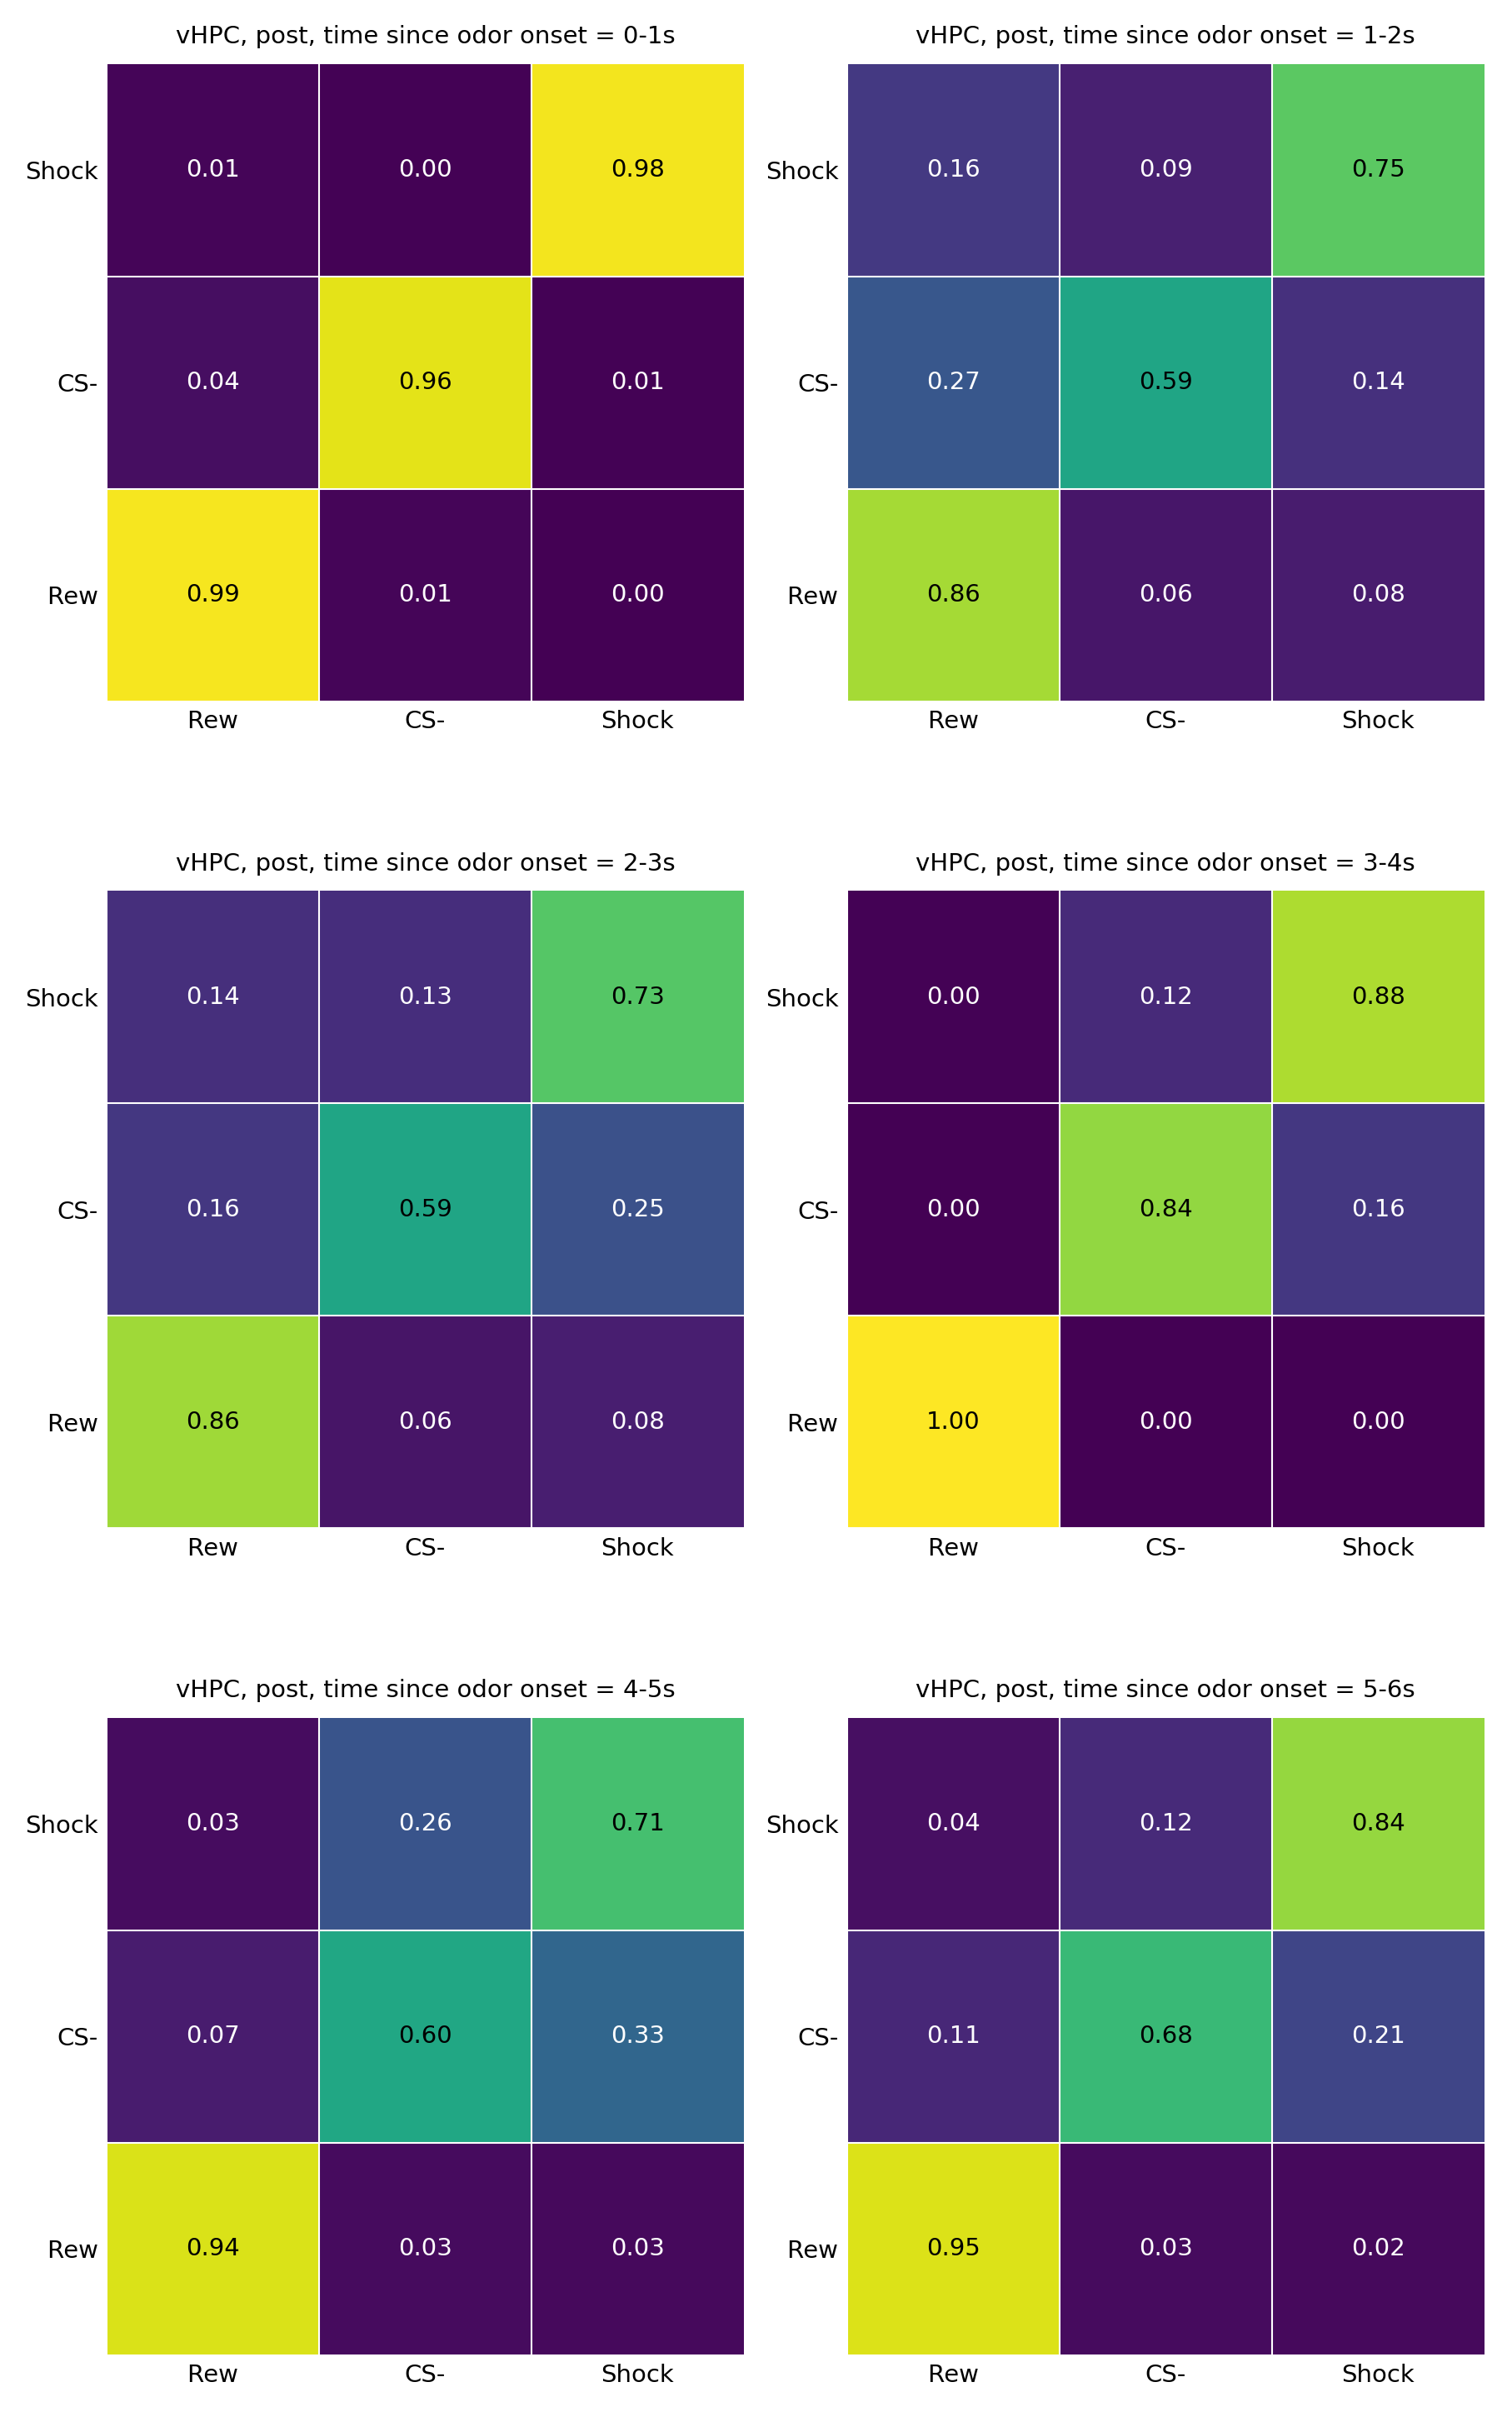

In [74]:
# plot 'em all

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = pl.subplots(3, 2, figsize=(6, 10))

for i,a in zip(range(3,9),range(6)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(3.*heatmaps_vhpc_1s_post[i]/np.sum(heatmaps_vhpc_1s_post[i]),(['Rew','CS-', 'Shock']),
                 (['Rew','CS-', 'Shock']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"vHPC, post, time since odor onset = %s-%ss"'%(str(i-3),str(i-2))))

pl.tight_layout()
pl.show()
#fig.savefig('../img/%s_vhpc_pre_ALL.jpg'%NOTEBOOK_NAME)

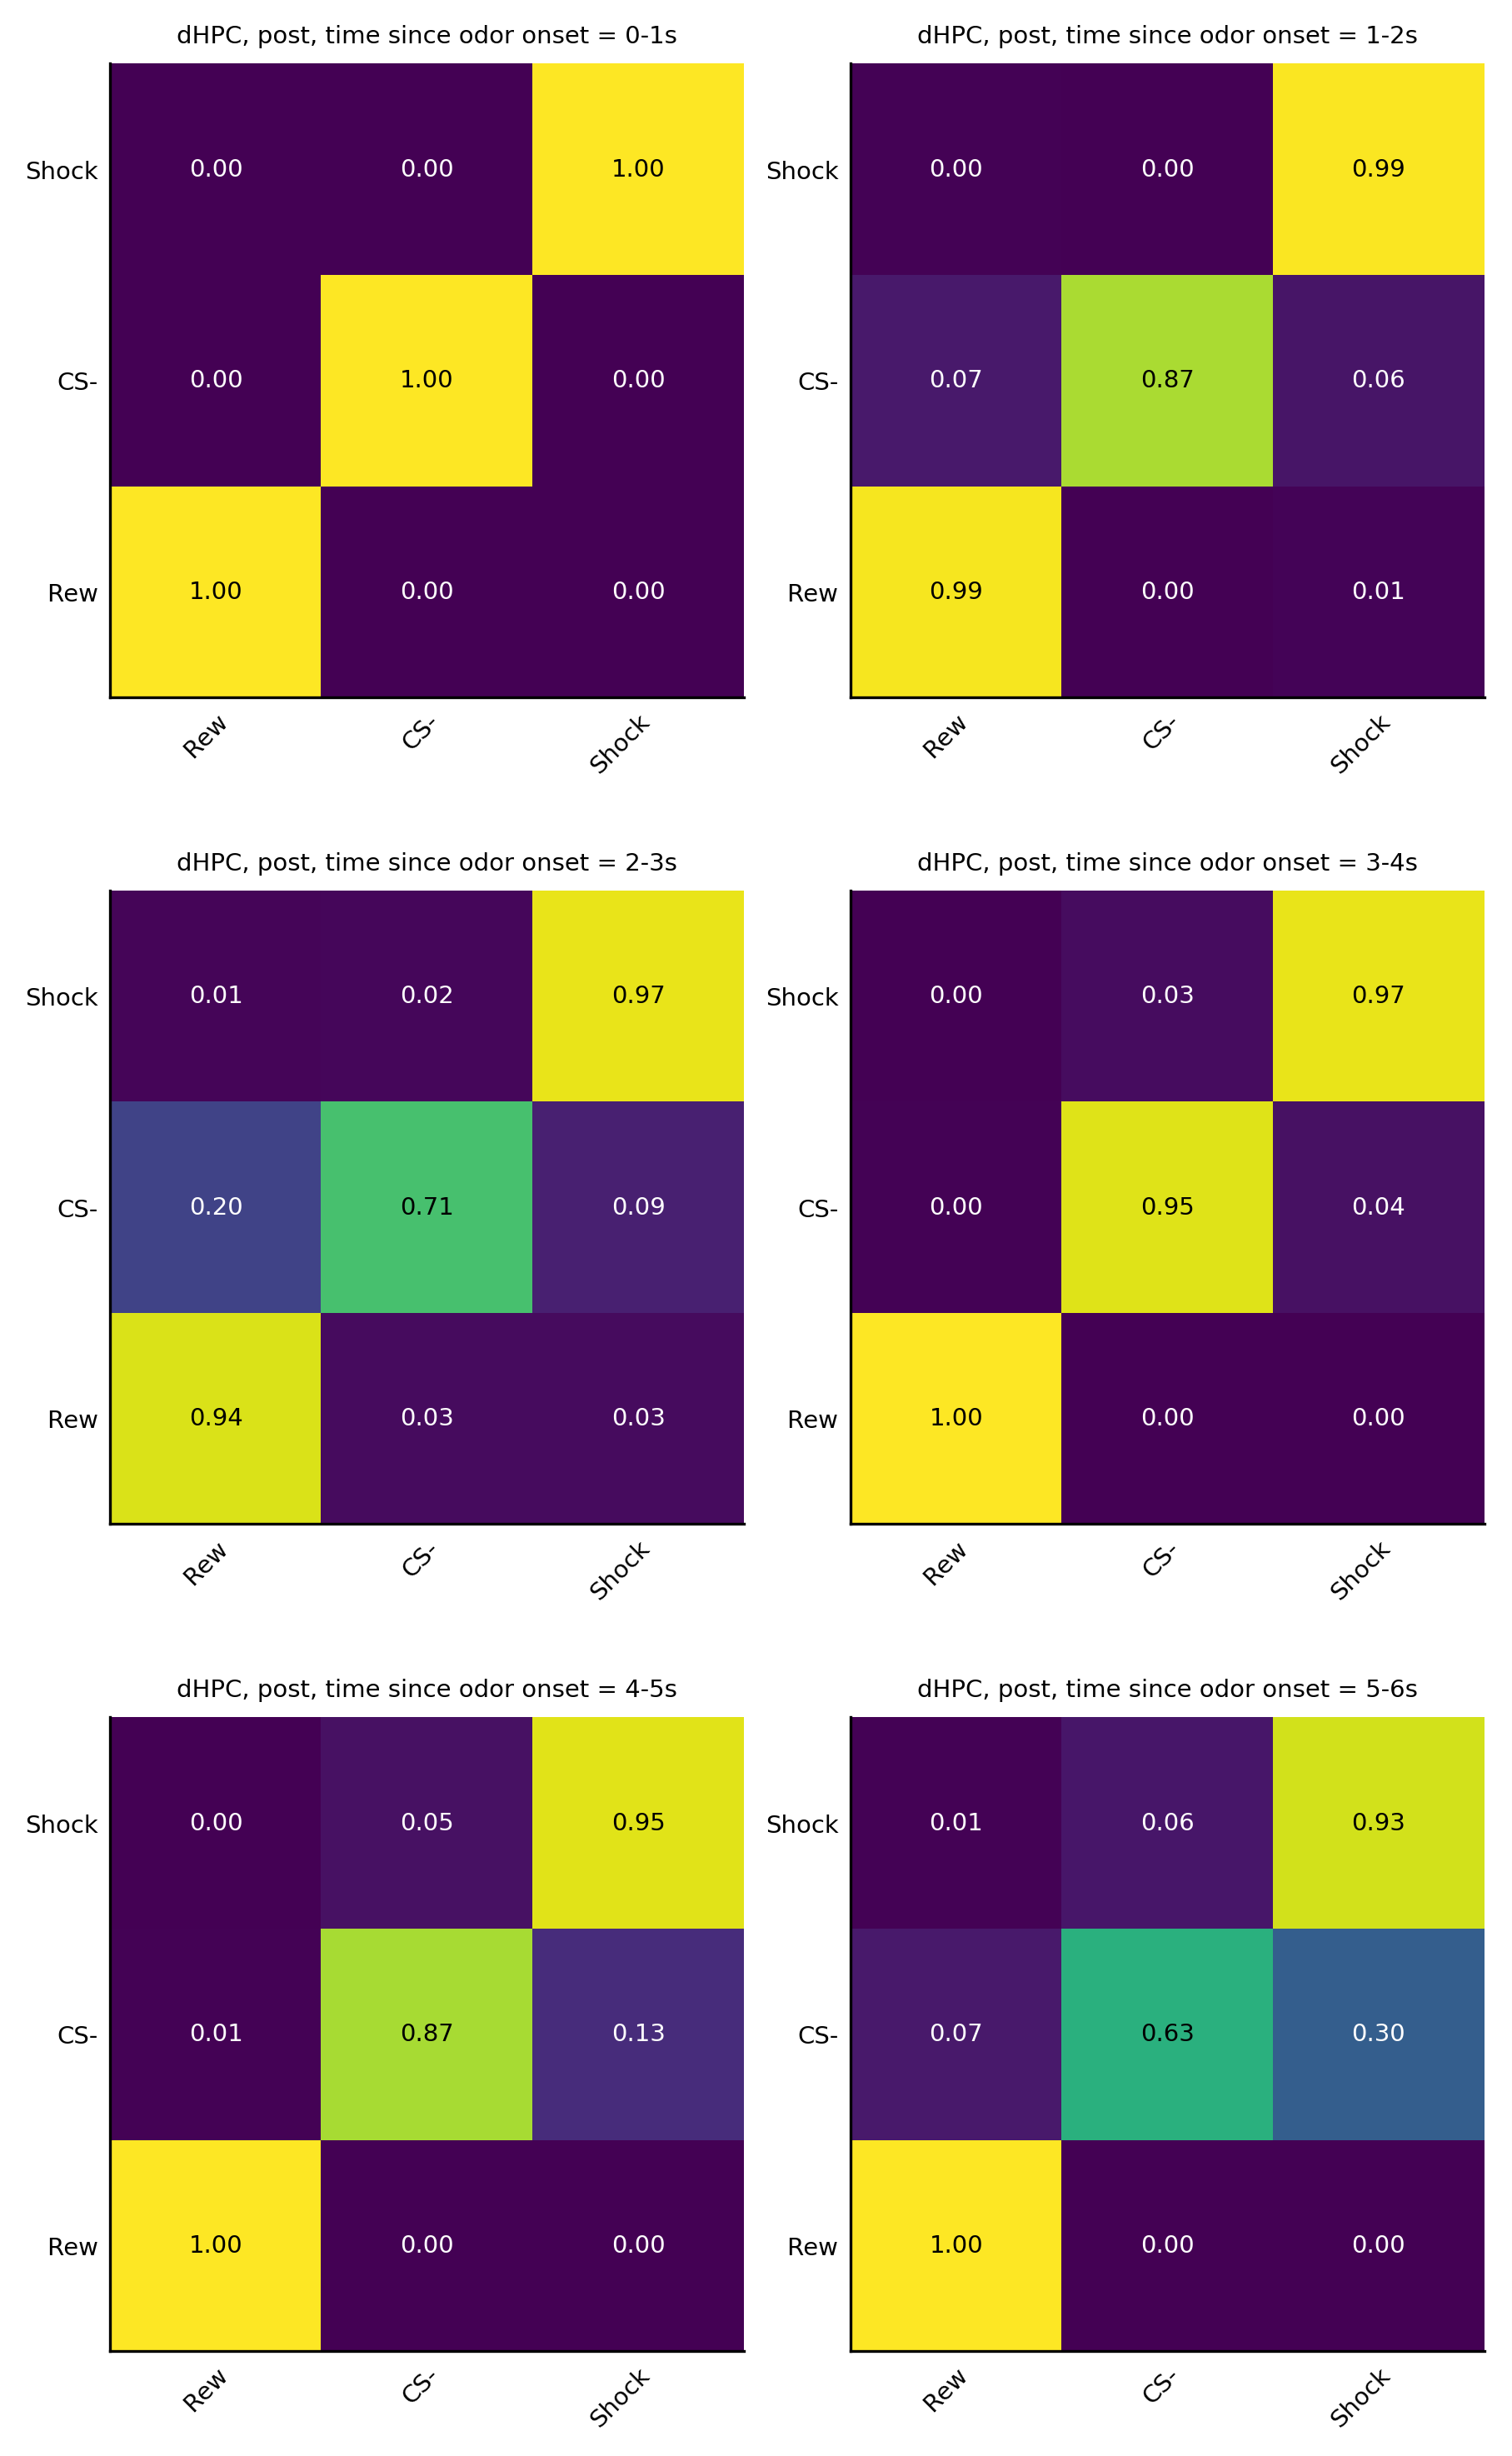

In [24]:
# plot 'em all

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = pl.subplots(3, 2, figsize=(6, 10))

for i,a in zip(range(3,9),range(6)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(3.*heatmaps_dhpc_1s_post[i]/np.sum(heatmaps_dhpc_1s_post[i]),(['Rew','CS-', 'Shock']),
                 (['Rew','CS-', 'Shock']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"dHPC, post, time since odor onset = %s-%ss"'%(str(i-3),str(i-2))))

pl.tight_layout()
pl.show()
#fig.savefig('../img/%s_vhpc_pre_ALL.jpg'%NOTEBOOK_NAME)

# Now for equalizing cell #s across all sess by using min

In [25]:
%%time
#for time bins durations of 0.5 and 1s, predict odor delivered for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for sess in 'post',:
        print reg,sess
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            try:
                for t in range(bin_ranges[i]): # number of time bins
                    print t,
                    for n in range(loops):
                        exec("predictions_gmin_%s_%s_%s_%s_%s, test_labels_gmin_%s_%s_%s = do_predict_within(patterns_%s_%s_%s_%s,\
                            labels_%s_%s,classes=range(5,8),n_cells=340)"%(reg,tb,sess,t,n,reg,sess,n,reg,tb,sess,t,reg,sess))
            except:
                print 'NOPE',

computing loop: dhpc post
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 0 1 2 3 4 5 6 7 8 9 10 11 12 13 vhpc post
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 0 1 2 3 4 5 6 7 8 9 10 11 12 13CPU times: user 4h 30min 50s, sys: 17min 35s, total: 4h 48min 25s
Wall time: 12min 2s



In [26]:
#append all loops
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                exec("predictions_gmin_%s_%s_%s_%s_appended = np.append(predictions_gmin_%s_%s_%s_%s_0,predictions_gmin_%s_%s_%s_%s_1)"%(reg,
                                                                                        tb,sess,t,reg,tb,sess,t,reg,tb,sess,t))
                exec("test_labels_gmin_%s_%s_appended = np.append(test_labels_gmin_%s_%s_0,test_labels_gmin_%s_%s_1)"%(reg,sess,reg,sess,reg,sess))
                for n in range(2,loops):
                    exec("predictions_gmin_%s_%s_%s_%s_appended = np.append(predictions_gmin_%s_%s_%s_%s_appended,predictions_gmin_%s_%s_%s_%s_%s)"%(reg,
                                                                                        tb,sess,t,reg,tb,sess,t,reg,tb,sess,t,n))
                    exec("test_labels_gmin_%s_%s_appended = np.append(test_labels_gmin_%s_%s_appended,test_labels_gmin_%s_%s_%s)"%(reg,sess,reg,sess,reg,sess,n))

In [27]:
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                exec('conf_matr_gmin_%s_%s_%s_%s_appended = confusion_matrix(test_labels_gmin_%s_%s_appended,\
                      predictions_gmin_%s_%s_%s_%s_appended)'%(reg,tb,sess,t,reg,sess,reg,tb,sess,t))

In [28]:
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            exec("heatmaps_gmin_%s_%s_%s = []")%(reg,tb,sess)
            for t in range(bin_ranges[i]): # number of time bins
                exec("heatmaps_gmin_%s_%s_%s.append(conf_matr_gmin_%s_%s_%s_%s_appended)"%(reg,tb,sess,reg,tb,sess,t))


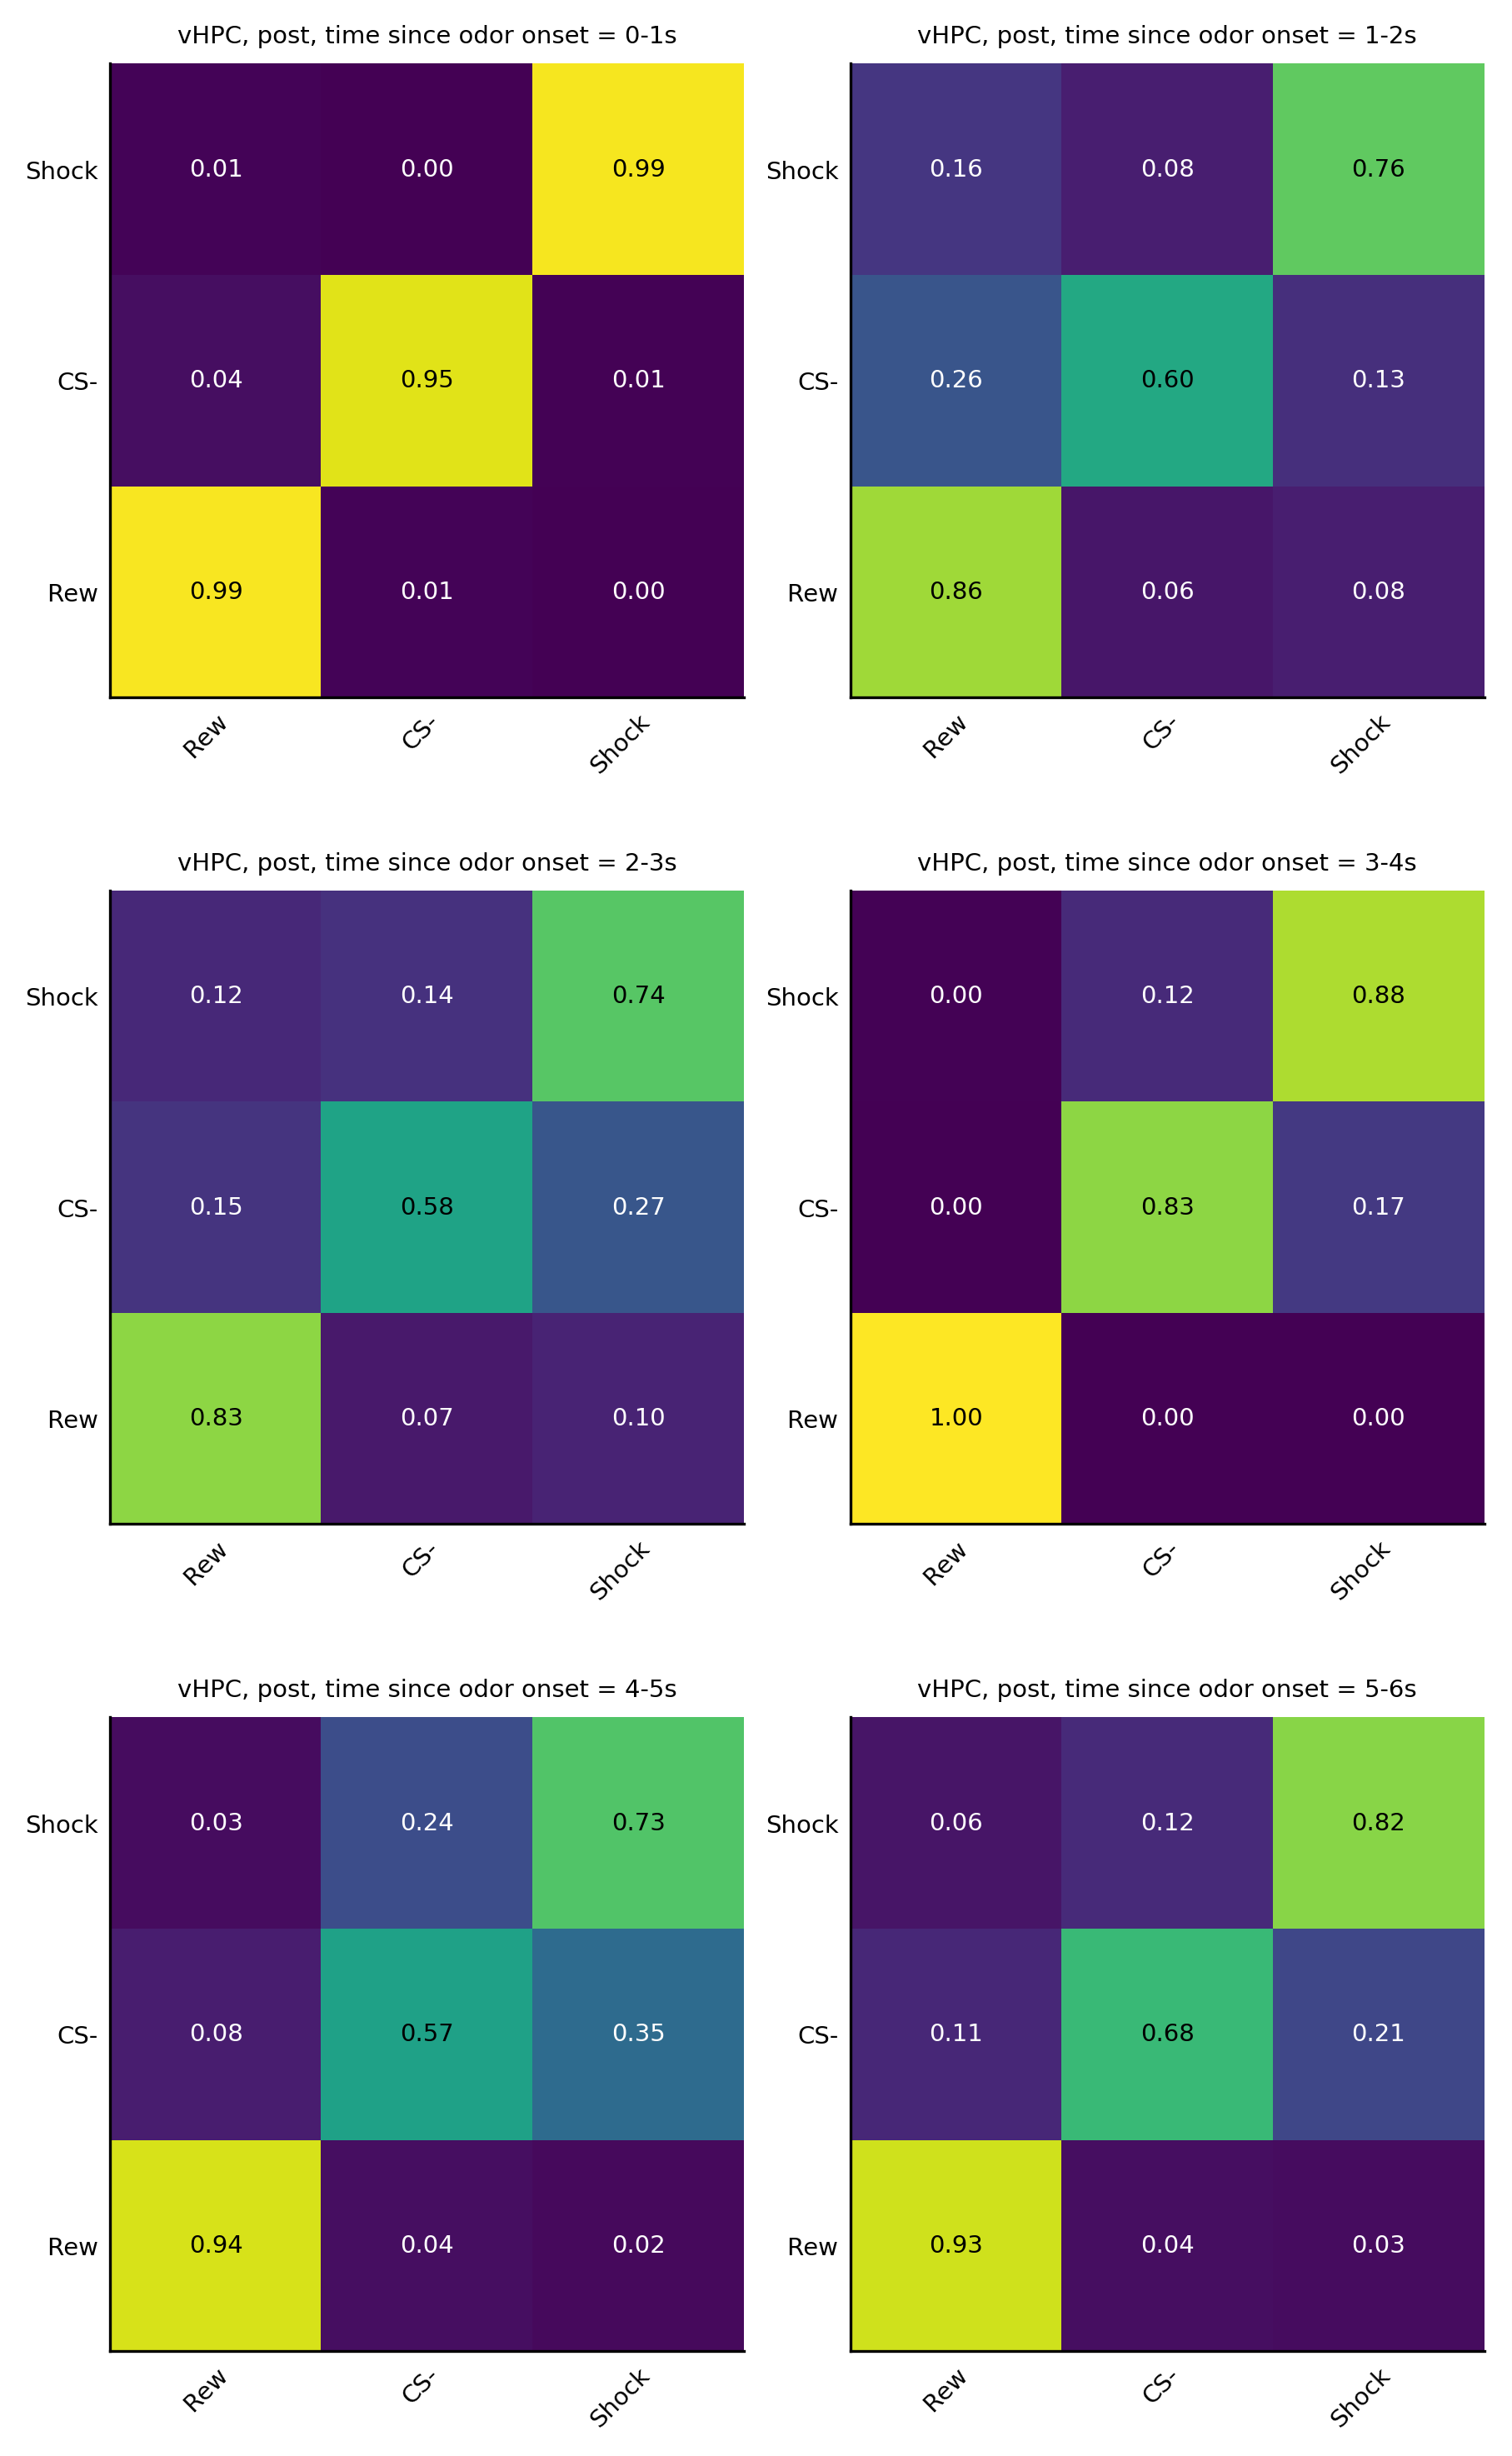

In [29]:
# plot 'em all

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = pl.subplots(3, 2, figsize=(6, 10))

for i,a in zip(range(3,9),range(6)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(3.*heatmaps_gmin_vhpc_1s_post[i]/np.sum(heatmaps_gmin_vhpc_1s_post[i]),(['Rew','CS-', 'Shock']),
                 (['Rew','CS-', 'Shock']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"vHPC, post, time since odor onset = %s-%ss"'%(str(i-3),str(i-2))))

pl.tight_layout()
pl.show()
#fig.savefig('../img/%s_vhpc_pre_ALL.jpg'%NOTEBOOK_NAME)

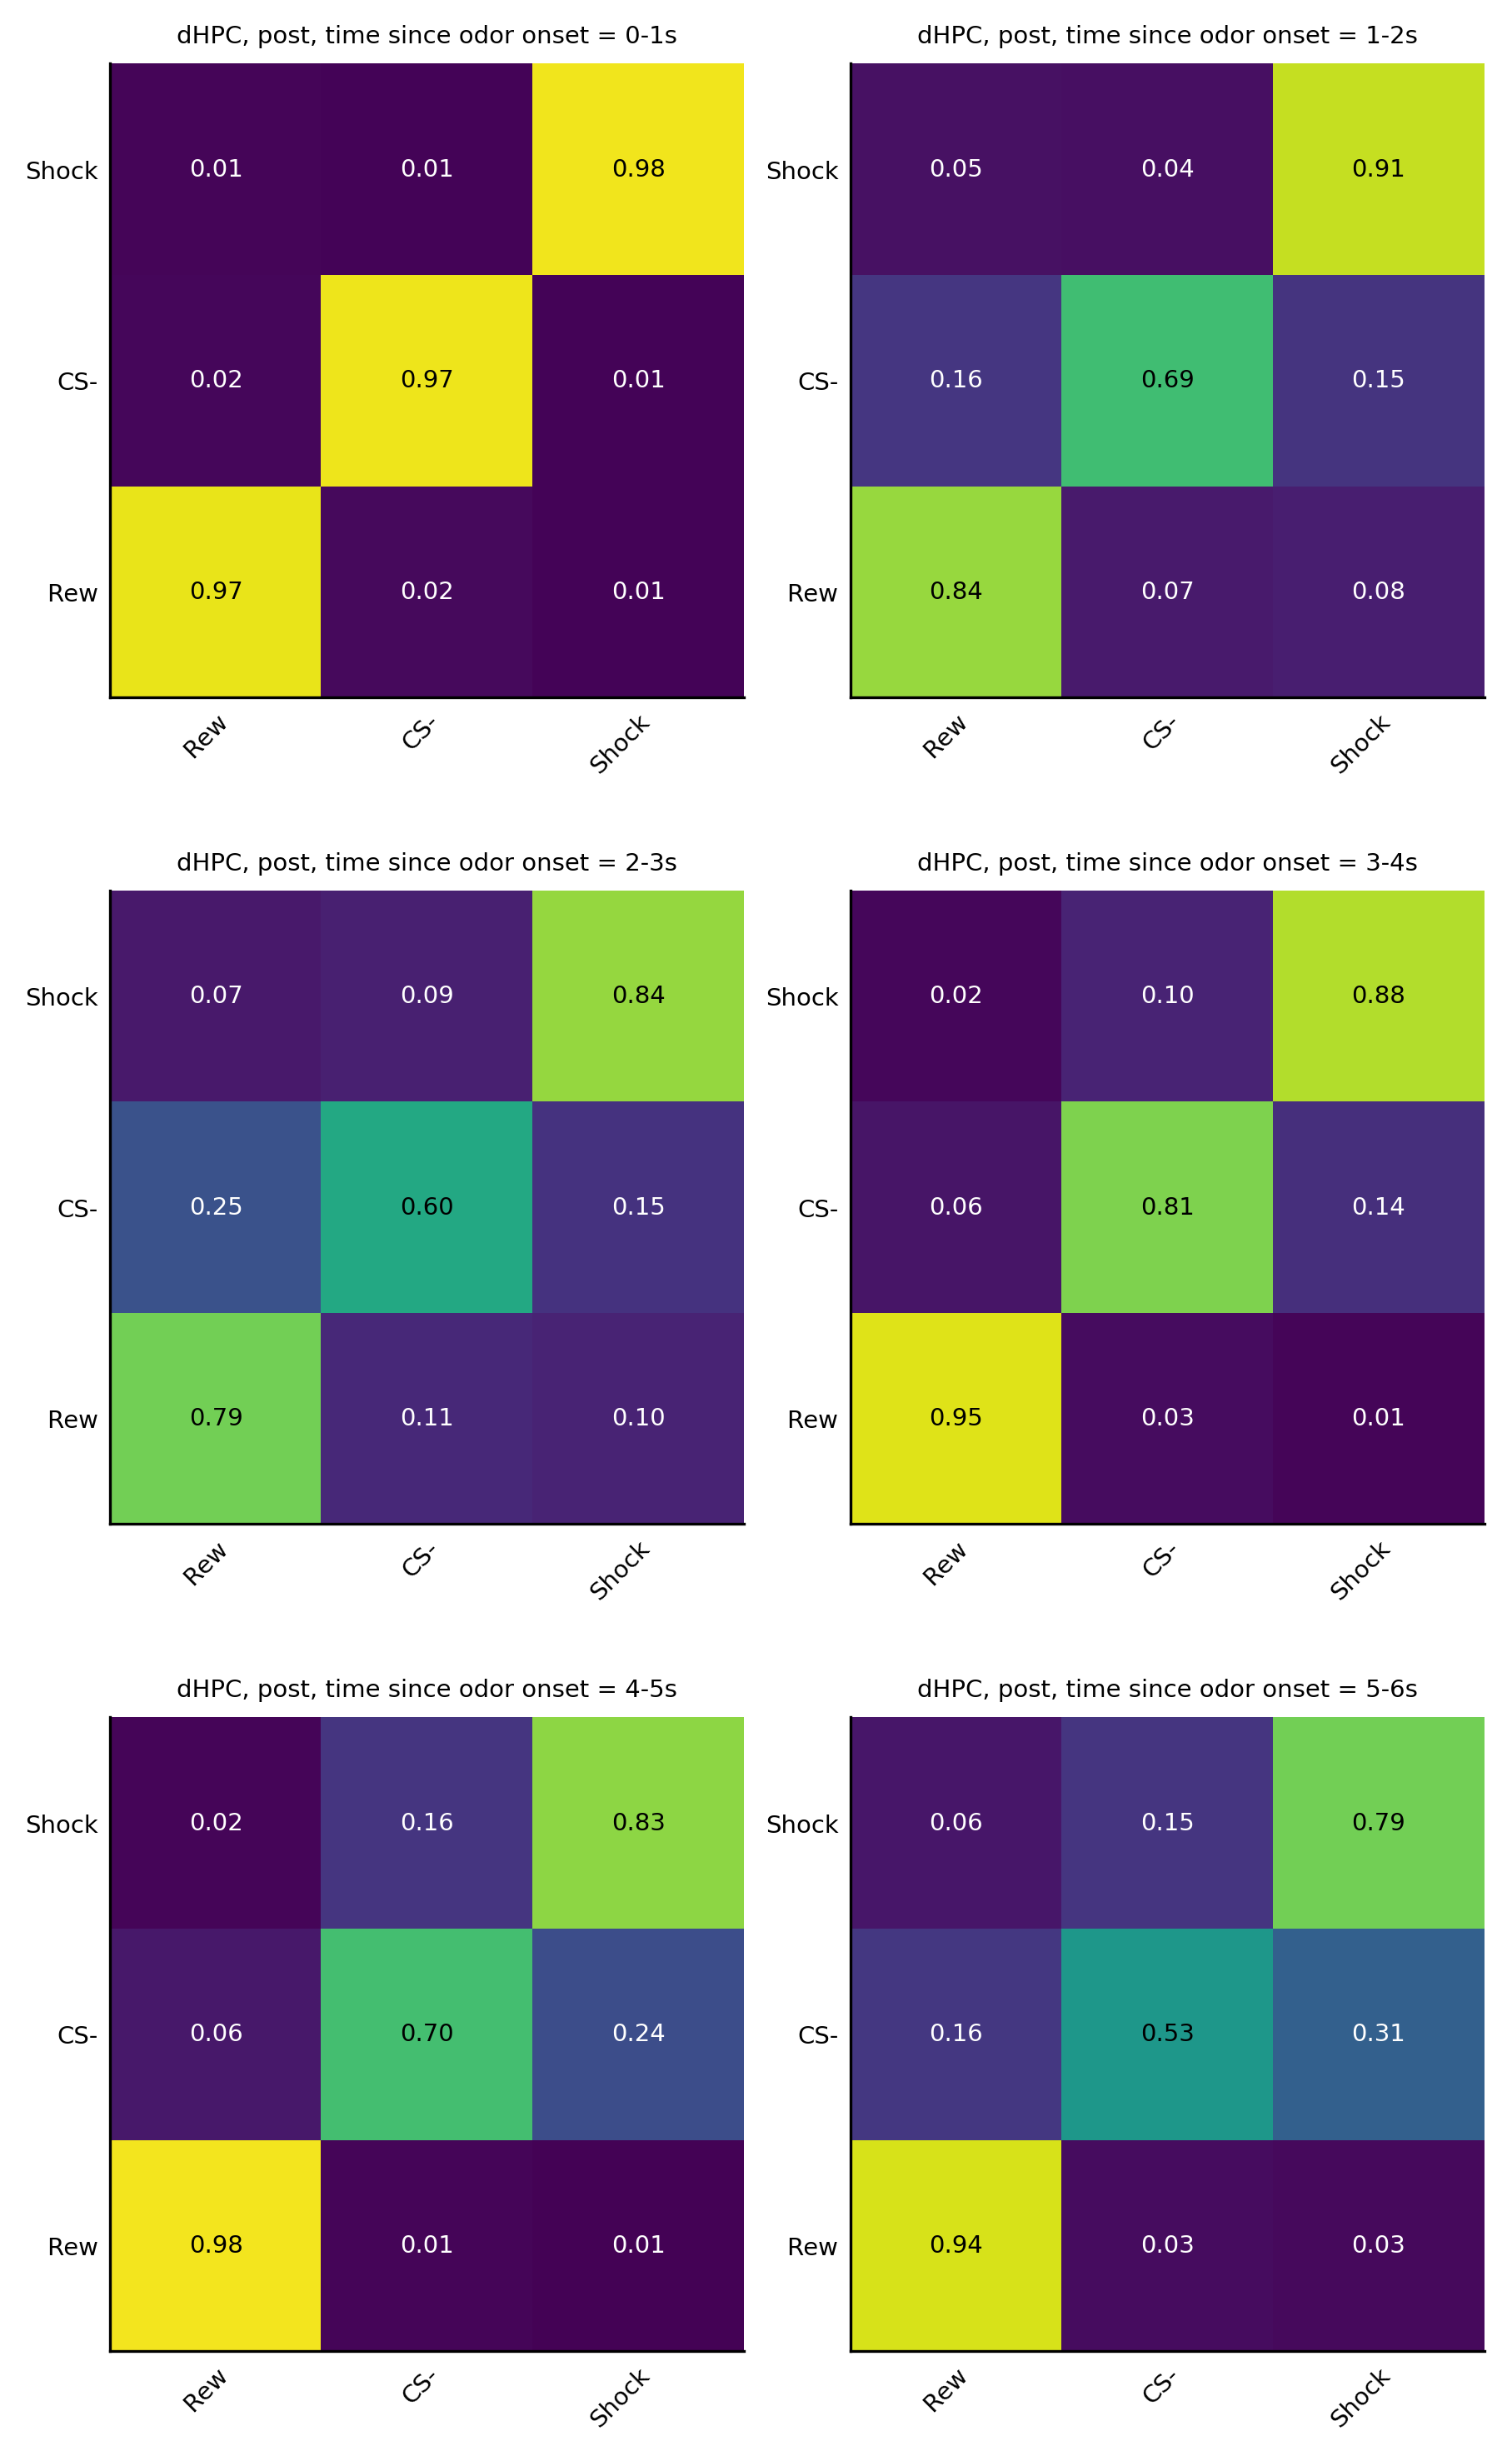

In [30]:
# plot 'em all

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = pl.subplots(3, 2, figsize=(6, 10))

for i,a in zip(range(3,9),range(6)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(3.*heatmaps_gmin_dhpc_1s_post[i]/np.sum(heatmaps_gmin_dhpc_1s_post[i]),(['Rew','CS-', 'Shock']),
                 (['Rew','CS-', 'Shock']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"dHPC, post, time since odor onset = %s-%ss"'%(str(i-3),str(i-2))))

pl.tight_layout()
pl.show()
#fig.savefig('../img/%s_vhpc_pre_ALL.jpg'%NOTEBOOK_NAME)

## reduce trial type sample size to common quantity across trial types and animals (so that each animal contributes equally, for trial number at least)

In [31]:
def combine_train_test_patterns_num_trials(patterns, labels, num_trials, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    patterns_t={}
    patterns_T={}
    labels_t={}
    labels_T={}
    not_run=[]
    tot_trials=0
    for ani in patterns.keys():
        #only analyze if have > 5 trials of each trial type
        if (np.sum(labels[ani]==classes[0])>=5) and (np.sum(labels[ani]==classes[1])>=5) and (np.sum(labels[ani]==classes[2])>=5): #only include animal if it has x trials of specified trial type
            which_trains = []
            which_tests = []
            #find min number of trials of both trial types, then downsample the type with more trials to match min
            #need here to ensure you get the same# of trials for each type in the case where min# of trials for either is < num_trials
            min_trials1=np.sum(labels[ani]==classes[0])
            min_trials2=np.sum(labels[ani]==classes[1])
            min_trials3=np.sum(labels[ani]==classes[2])
            min_trials=min(min_trials1,min_trials2,min_trials3)      
            if min_trials < num_trials:
                print ani,"trials:",min_trials,"     ",
            tot_trials = tot_trials + min(min_trials,num_trials)
            for l in classes:
                if l>=0:
                    wt = np.random.permutation(np.where(labels[ani]==l)[0])[:min_trials]
                    # constrain number of trials to be consistent across conditions
                    wt = wt[:num_trials]
                    if train_test_split<1: #split trials into train and test subsets (ratio set by "train_test_split" value)
                        wT = wt[:int(len(wt)*train_test_split)]
                        which_trains.append(wt[int(len(wt)*train_test_split):])
                        which_tests.append(wT)
                    else:
                        which_trains.append(wt)
            which_train[ani] = np.concatenate(which_trains)
            if train_test_split<1:
                which_test[ani] = np.concatenate(which_tests)
        else:
            not_run.append(ani)
    for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
        #patterns_t[ani] = patterns[ani].copy()
        #labels_t[ani] = labels[ani].copy()
        #print which_train.keys()
    #for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
    #    print ani
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = combine_patterns(patterns_t, labels_t, classes=classes)

        
    if train_test_split<1:
        for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
            #patterns_T[ani] = patterns[ani].copy()
            #labels_T[ani] = labels[ani].copy()
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
        
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0],not_run,which_cells,tot_trials)
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None,not_run,which_cells)
    
def do_test_within_num_trials(patterns, labels, num_trials, **args):
    x, y, xT, yT,not_run,which_cells,tot_trials = combine_train_test_patterns_num_trials(patterns, labels, num_trials, **args)
    decoder.fit(x, y)
    #print "Not run:",not_run
    return decoder.score(xT, yT)

def do_predict_within_num_trials(patterns, labels, num_trials, **args):
    x, y, xT, test_labels,not_run,which_cells,tot_trials = combine_train_test_patterns_num_trials(patterns, labels, num_trials,**args)
    decoder.fit(x, y)
    return decoder.predict(xT), test_labels

def Not_Run(patterns, labels, num_trials,**args):
    x, y, xT, yT,not_run,which_cells,tot_trials = combine_train_test_patterns_num_trials(patterns, labels, num_trials,**args)
    return not_run,len(which_cells),tot_trials

In [32]:
%%time
#for time bins durations of 0.5 and 1s, predict odor delivered for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for sess in 'post',:
        print reg,sess
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            #try:
                for t in range(bin_ranges[i]): # number of time bins
                    print t,
                    for n in range(loops):
                        exec("predictions_gmins_%s_%s_%s_%s_%s, test_labels_gmins_%s_%s_%s = do_predict_within_num_trials(patterns_%s_%s_%s_%s,\
                            labels_%s_%s,num_trials=15,classes=range(5,8),n_cells=340)"%(reg,tb,sess,t,n,reg,sess,n,reg,tb,sess,t,reg,sess))
            #except:
            #    print 'NOPE',

computing loop: dhpc post
0 dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b tria

In [99]:
for reg in 'vhpc','dhpc':
    for od in [5,6,7]:
        for sess in 'post',:
            exec("odor%s_correct_%s=[]"%(od,sess))
            for n in range(10,20):
                correct=0
                for i in range(len(predictions_gmin_vhpc_1s_post_5_0)):
                        if eval("predictions_gmins_%s_1s_%s_3_%s[i]==%s"%(reg,sess,n,od)) and eval("test_labels_gmin_%s_%s_0[i]==%s"%(reg,sess,od)):
                            correct=correct+3.3
                exec("odor%s_correct_%s.append(correct)"%(od,sess))
            print reg,sess,od,eval("odor%s_correct_%s"%(od,sess)), eval("np.mean(odor%s_correct_%s)"%(od,sess))

vhpc post 5 [98.99999999999994, 98.99999999999994, 95.69999999999995, 98.99999999999994, 98.99999999999994, 98.99999999999994, 98.99999999999994, 98.99999999999994, 92.39999999999995, 98.99999999999994] 98.01
vhpc post 6 [98.99999999999994, 95.69999999999995, 95.69999999999995, 65.99999999999997, 92.39999999999995, 98.99999999999994, 98.99999999999994, 98.99999999999994, 98.99999999999994, 89.09999999999995] 93.39
vhpc post 7 [98.99999999999994, 98.99999999999994, 98.99999999999994, 95.69999999999995, 95.69999999999995, 98.99999999999994, 98.99999999999994, 98.99999999999994, 98.99999999999994, 98.99999999999994] 98.34
dhpc post 5 [89.09999999999995, 98.99999999999994, 85.79999999999995, 98.99999999999994, 95.69999999999995, 89.09999999999995, 85.79999999999995, 92.39999999999995, 98.99999999999994, 98.99999999999994] 93.39
dhpc post 6 [98.99999999999994, 95.69999999999995, 98.99999999999994, 82.49999999999996, 98.99999999999994, 98.99999999999994, 98.99999999999994, 98.99999999999994,

In [9]:
for reg in 'vhpc','dhpc':
    for od in [5,6,7]:
        for sess in 'post',:
            exec("trace%s_correct_%s=[]"%(od,sess))
            for n in range(10,20):
                correct=0
                for i in range(len(predictions_gmin_vhpc_1s_post_5_0)):
                        if eval("predictions_gmins_%s_1s_%s_6_%s[i]==%s"%(reg,sess,n,od)) and eval("test_labels_gmin_%s_%s_0[i]==%s"%(reg,sess,od)):
                            correct=correct+3.3
                exec("trace%s_correct_%s.append(correct)"%(od,sess))
            print reg,sess,od,eval("trace%s_correct_%s"%(od,sess)), eval("np.mean(trace%s_correct_%s)"%(od,sess))

vhpc post 5 [98.99999999999994, 98.99999999999994, 98.99999999999994, 98.99999999999994, 98.99999999999994, 98.99999999999994, 92.39999999999995, 98.99999999999994, 98.99999999999994, 95.69999999999995] 98.01
vhpc post 6 [95.69999999999995, 92.39999999999995, 79.19999999999996, 82.49999999999996, 92.39999999999995, 92.39999999999995, 82.49999999999996, 89.09999999999995, 92.39999999999995, 98.99999999999994] 89.76
vhpc post 7 [72.59999999999997, 98.99999999999994, 98.99999999999994, 98.99999999999994, 98.99999999999994, 79.19999999999996, 69.29999999999997, 56.09999999999998, 82.49999999999996, 79.19999999999996] 83.49
dhpc post 5 [92.39999999999995, 92.39999999999995, 98.99999999999994, 98.99999999999994, 98.99999999999994, 95.69999999999995, 98.99999999999994, 98.99999999999994, 95.69999999999995, 98.99999999999994] 97.02
dhpc post 6 [52.79999999999998, 79.19999999999996, 56.09999999999998, 72.59999999999997, 46.19999999999999, 89.09999999999995, 95.69999999999995, 62.699999999999974

In [33]:
#append all loops
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                exec("predictions_gmins_%s_%s_%s_%s_appended = np.append(predictions_gmins_%s_%s_%s_%s_0,predictions_gmins_%s_%s_%s_%s_1)"%(reg,
                                                                                        tb,sess,t,reg,tb,sess,t,reg,tb,sess,t))
                exec("test_labels_gmins_%s_%s_appended = np.append(test_labels_gmins_%s_%s_0,test_labels_gmins_%s_%s_1)"%(reg,sess,reg,sess,reg,sess))
                for n in range(2,loops):
                    exec("predictions_gmins_%s_%s_%s_%s_appended = np.append(predictions_gmins_%s_%s_%s_%s_appended,predictions_gmins_%s_%s_%s_%s_%s)"%(reg,
                                                                                        tb,sess,t,reg,tb,sess,t,reg,tb,sess,t,n))
                    exec("test_labels_gmins_%s_%s_appended = np.append(test_labels_gmins_%s_%s_appended,test_labels_gmins_%s_%s_%s)"%(reg,sess,reg,sess,reg,sess,n))

In [34]:
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                exec('conf_matr_gmins_%s_%s_%s_%s_appended = confusion_matrix(test_labels_gmins_%s_%s_appended,\
                      predictions_gmins_%s_%s_%s_%s_appended)'%(reg,tb,sess,t,reg,sess,reg,tb,sess,t))

In [35]:
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            exec("heatmaps_gmins_%s_%s_%s = []")%(reg,tb,sess)
            for t in range(bin_ranges[i]): # number of time bins
                exec("heatmaps_gmins_%s_%s_%s.append(conf_matr_gmins_%s_%s_%s_%s_appended)"%(reg,tb,sess,reg,tb,sess,t))


In [72]:
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None, cmap='viridis',
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = pl.gca()

    # Plot the heatmap
    im = ax.imshow(data, cmap, origin="lower", **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=7)
    ax.set_yticklabels(row_labels, fontsize=7)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
    #               labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    pl.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1])-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0])-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=.5)
    ax.tick_params(axis='both', which='both', bottom=False, left=False,pad=-1)

    return im#, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["white", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

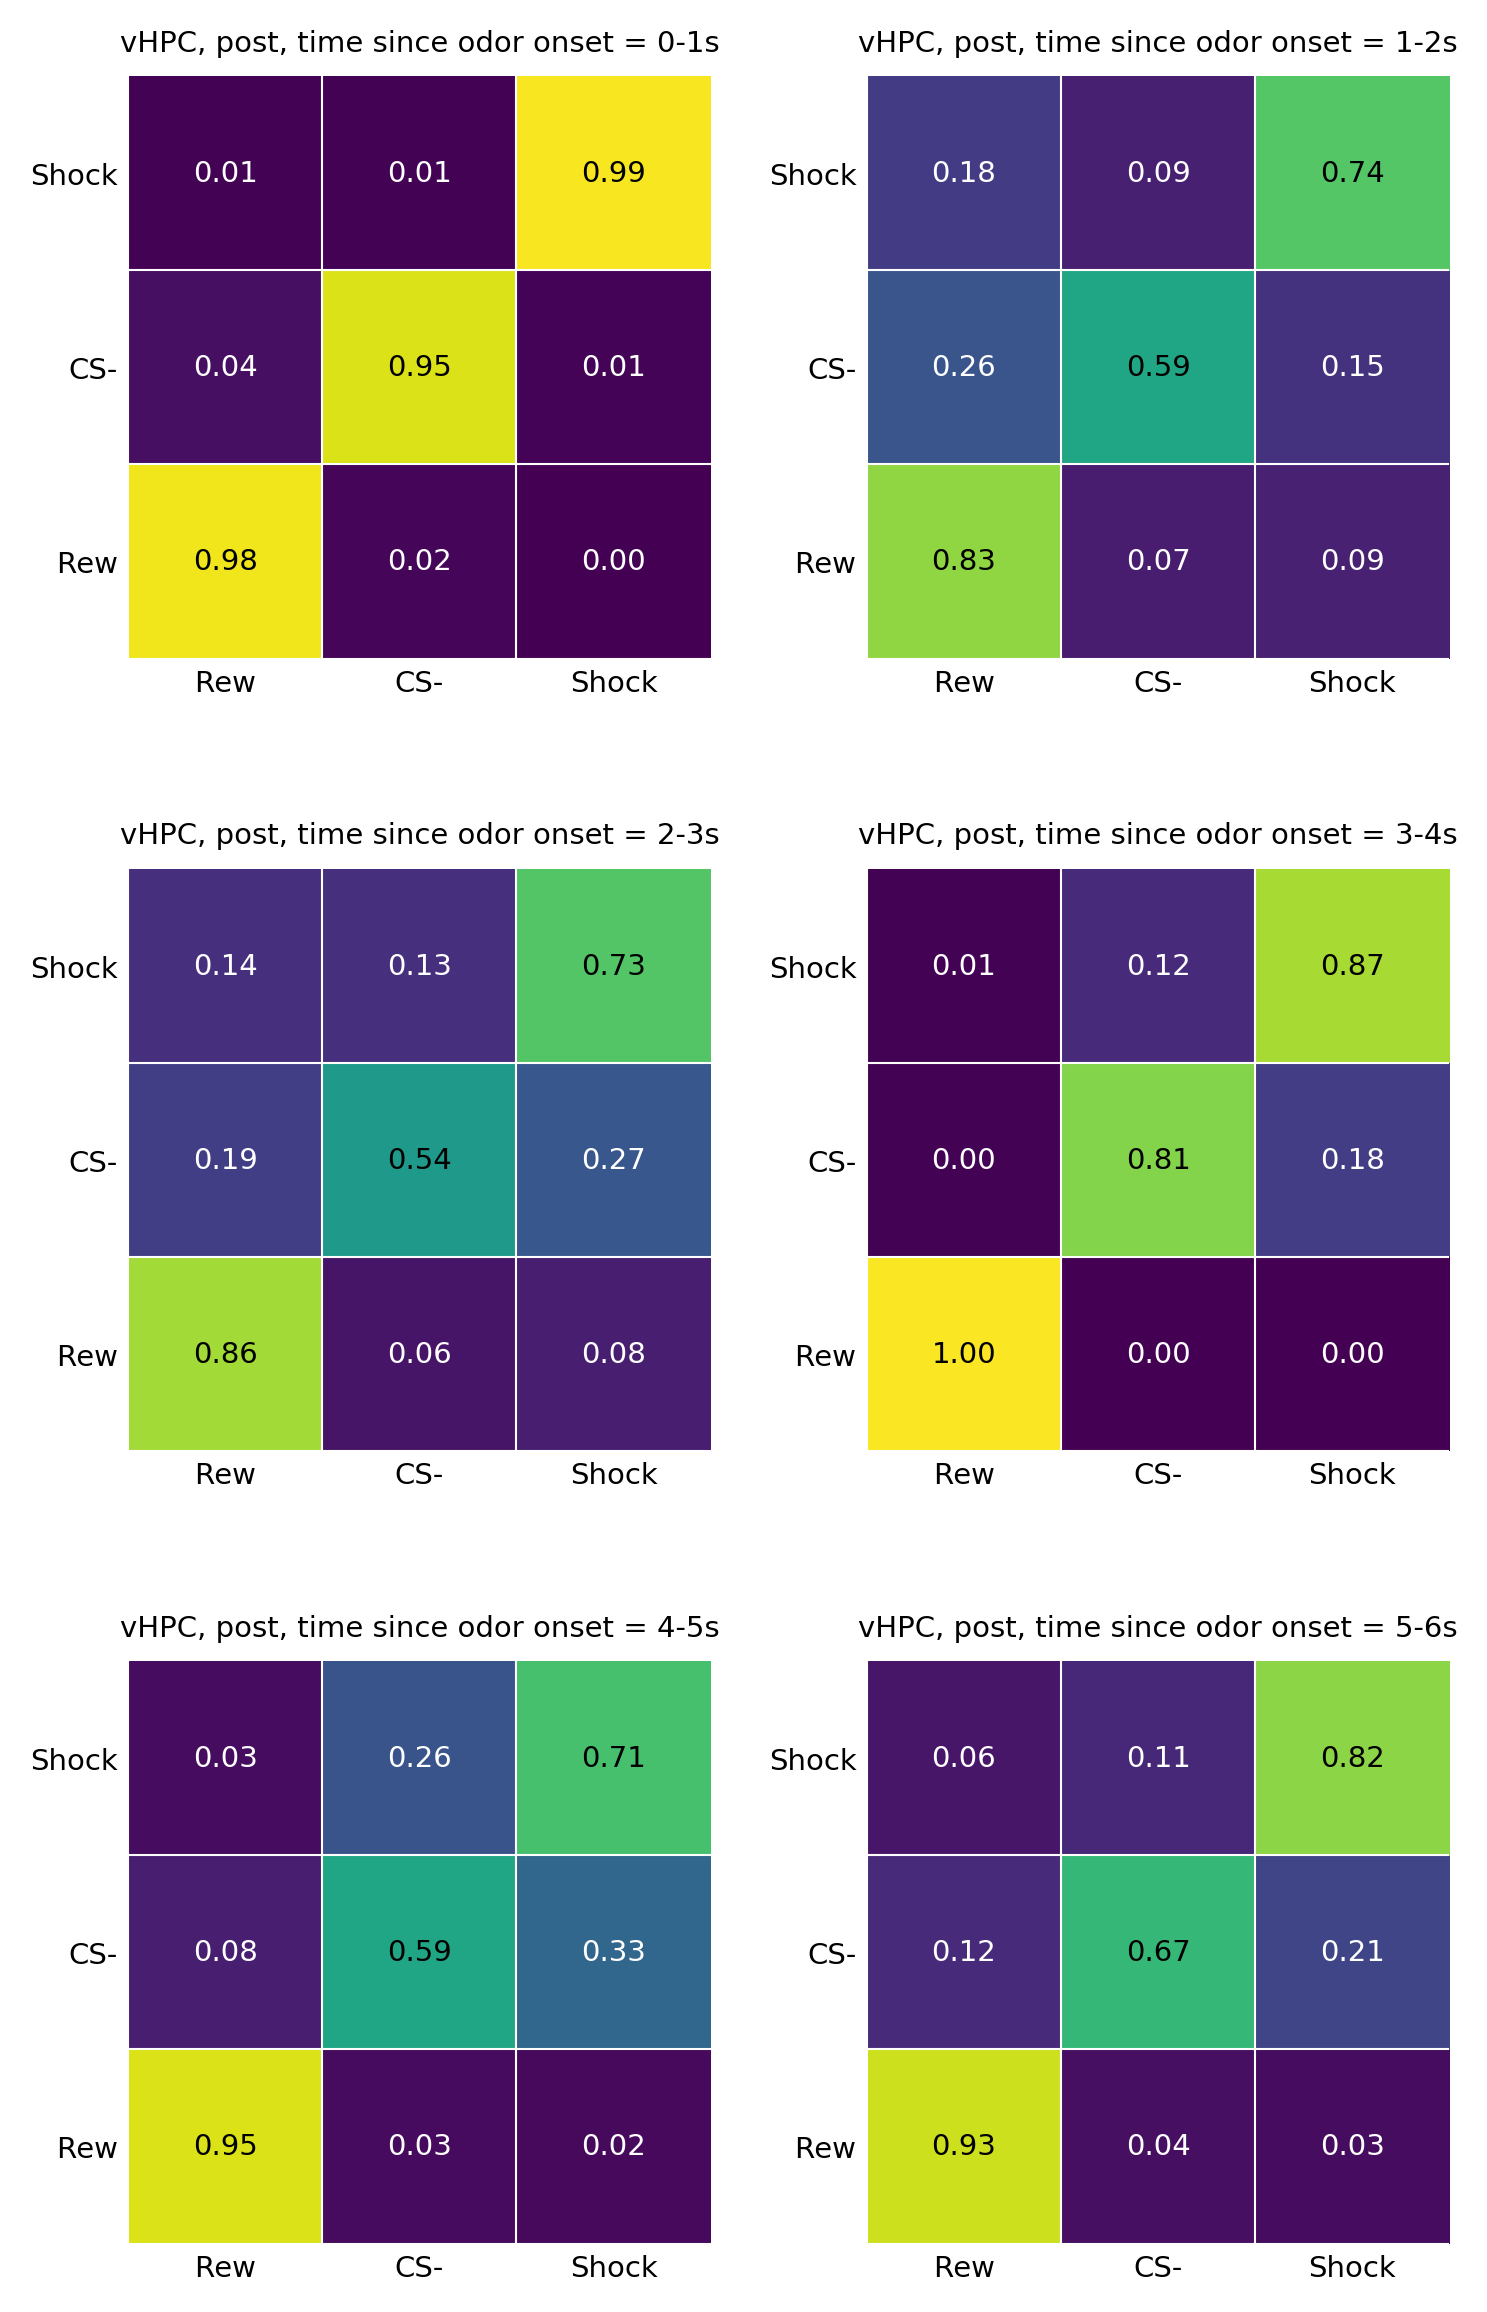

In [73]:
# plot 'em all

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = pl.subplots(3, 2, figsize=(5, 8))

for i,a in zip(range(3,9),range(6)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(3.*heatmaps_gmins_vhpc_1s_post[i]/np.sum(heatmaps_gmins_vhpc_1s_post[i]),(['Rew','CS-', 'Shock']),
                 (['Rew','CS-', 'Shock']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"vHPC, post, time since odor onset = %s-%ss"'%(str(i-3),str(i-2))))

pl.tight_layout()
pl.show()
#fig.savefig('../img/%s_vhpc_pre_ALL.jpg'%NOTEBOOK_NAME)

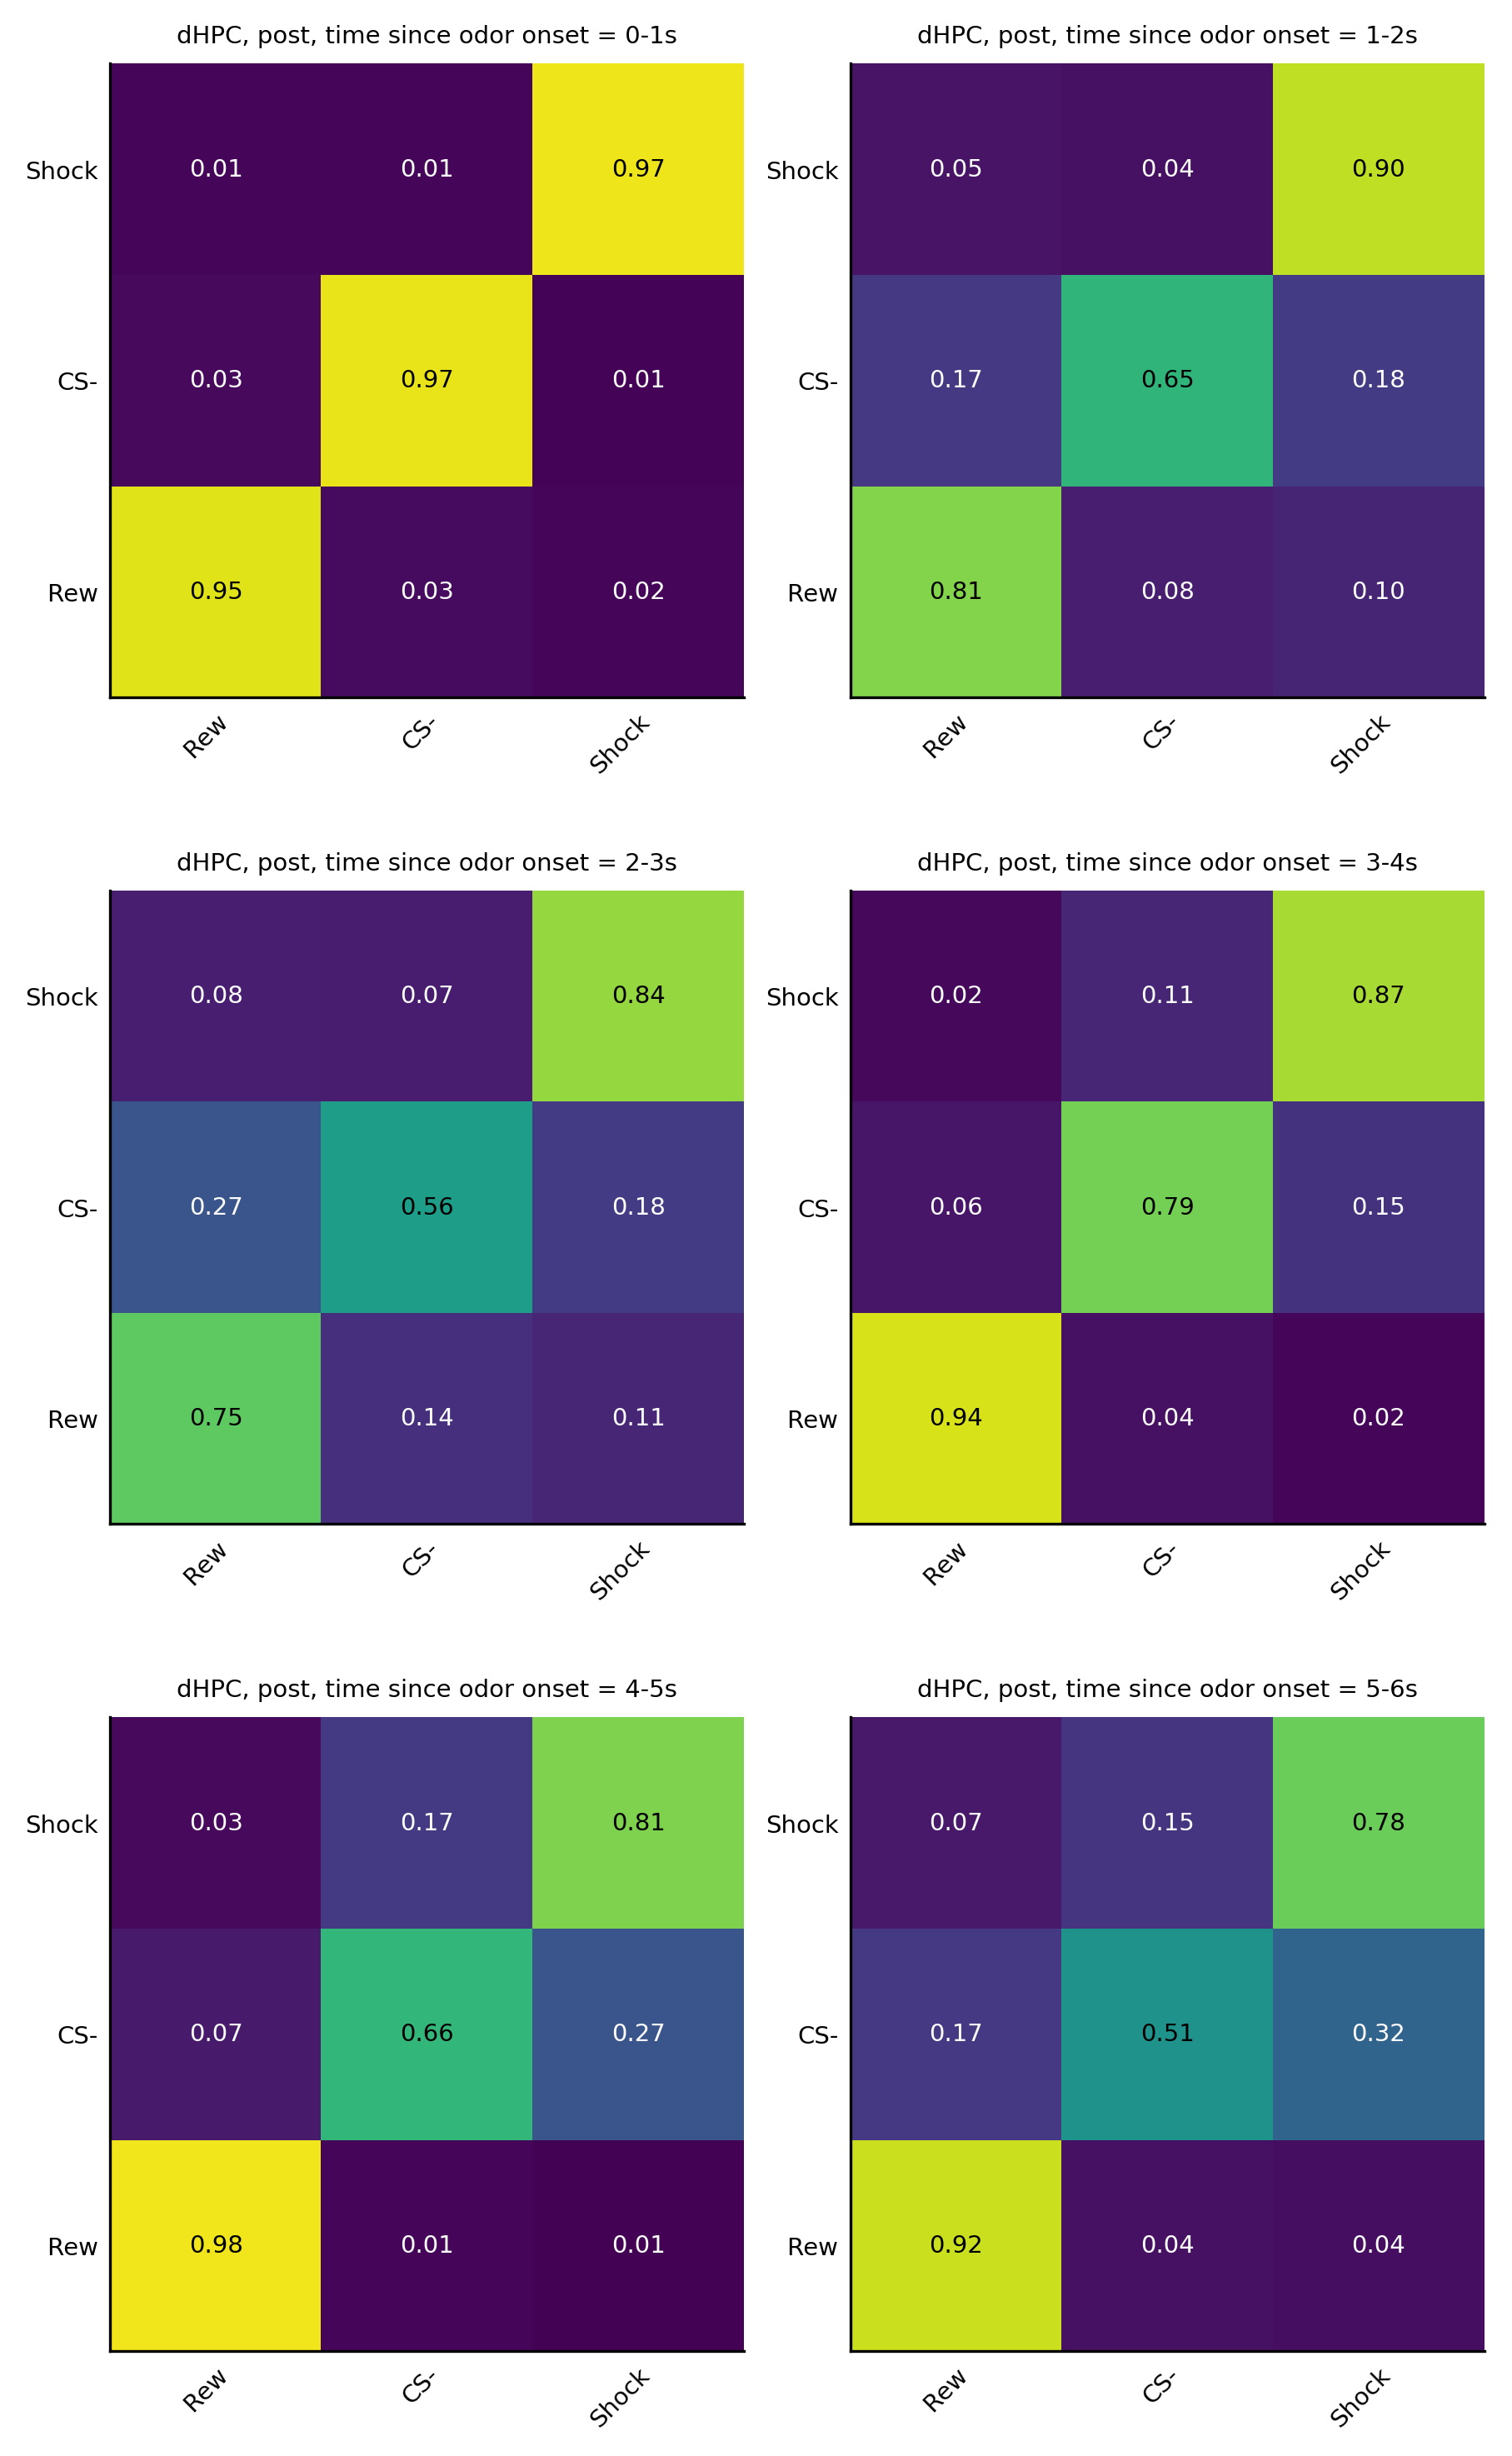

In [37]:
# plot 'em all

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = pl.subplots(3, 2, figsize=(6, 10))

for i,a in zip(range(3,9),range(6)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(3.*heatmaps_gmins_dhpc_1s_post[i]/np.sum(heatmaps_gmins_dhpc_1s_post[i]),(['Rew','CS-', 'Shock']),
                 (['Rew','CS-', 'Shock']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"dHPC, post, time since odor onset = %s-%ss"'%(str(i-3),str(i-2))))

pl.tight_layout()
pl.show()
#fig.savefig('../img/%s_vhpc_pre_ALL.jpg'%NOTEBOOK_NAME)

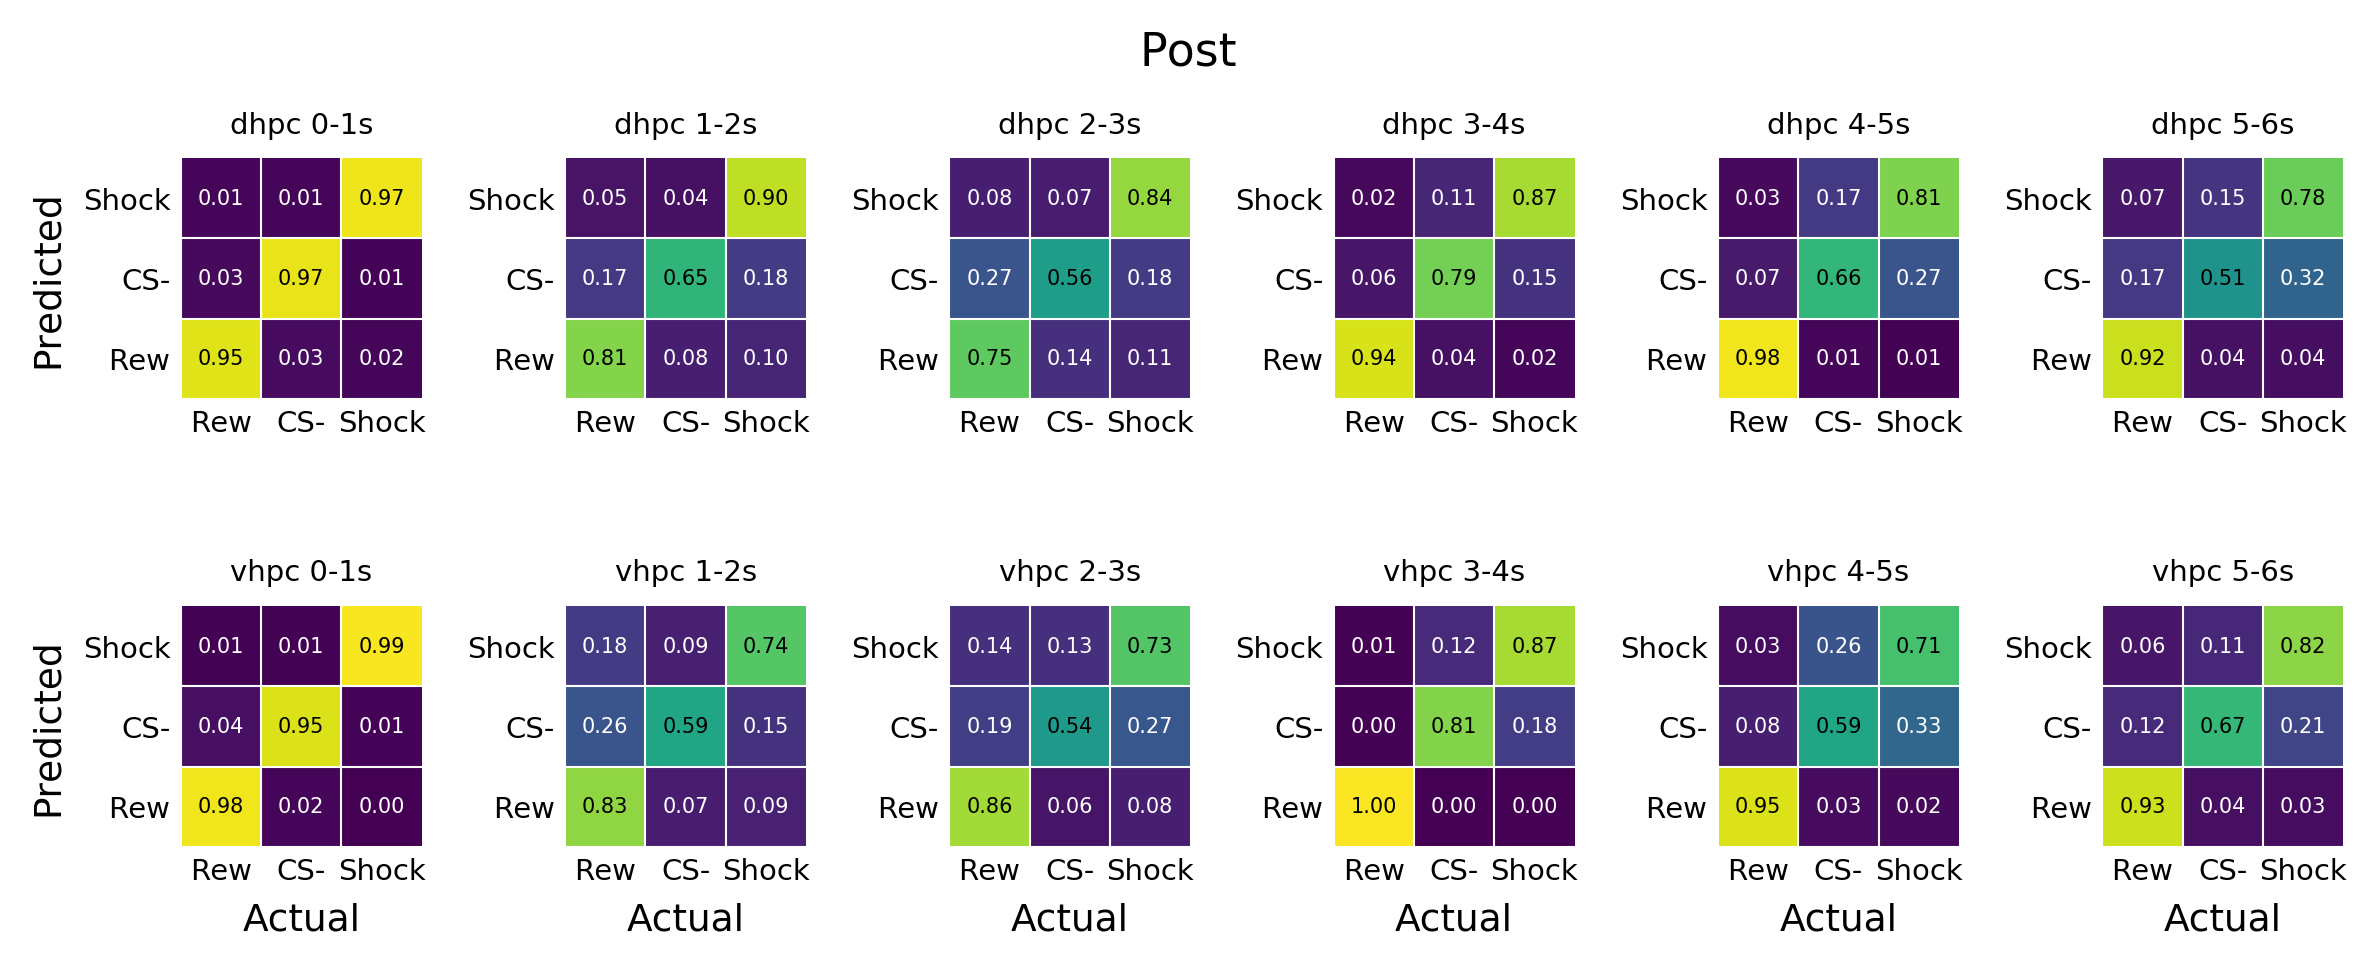

In [78]:
# plot 'em all
sess='post'
fig, ((ax1, ax2, ax3, ax4, ax5, ax6),(ax7,ax8,ax9,ax10,ax11,ax12)) = pl.subplots(2, 6, figsize=(8, 3.3))

for reg,r in zip(regions,(0,6)):
    for i,j,la in zip(range(3,9),range(1,7),('0-1s','1-2s','2-3s','3-4s','4-5s','5-6s')):
        q=j+r
        im = heatmap(eval("3.*heatmaps_gmins_%s_1s_%s[i]/np.sum(heatmaps_gmins_%s_1s_%s[i])"%(reg,sess,reg,sess)),(['Rew','CS-','Shock']),
                     (['Rew','CS-','Shock']), ax=eval('ax%s'%q),vmin=0,vmax=1)
        annotate_heatmap(im, valfmt="{x:.2f}", size=5)
        eval('ax%s'%q).set_title(eval('"%s %s"'%(reg,la)))
for x in range(7,13):
    eval('ax%s.set_xlabel'%x)('Actual',fontsize=9)
for x in 1,7:
    eval('ax%s.set_ylabel'%x)('Predicted',fontsize=9)
pl.suptitle('Post',fontsize=11,y=1)
    
pl.tight_layout(pad=2)
pl.show()
#fig.savefig('../figures/%s_vhpc_prepost_1s.pdf'%NOTEBOOK_NAME)

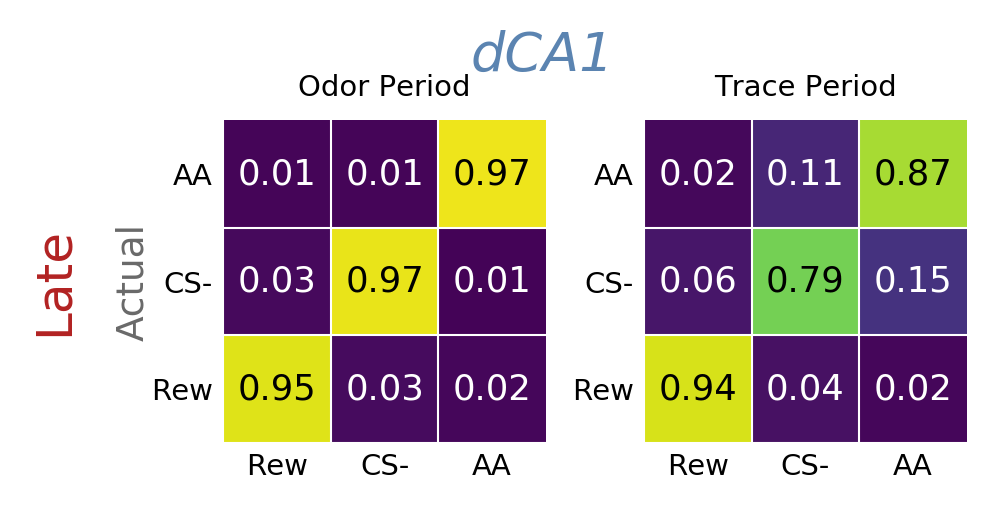

In [88]:
fig, (ax0,ax1) = pl.subplots(1, 2, figsize=(3, 1.5))

for sess,x,c in zip(['post','post'],range(2),[0,2]):
    for i,tb,la in zip(range(2),[3,6],['Odor Period','Trace Period']):
        y = 2*x+i
        im = heatmap(3.*eval("heatmaps_gmins_dhpc_1s_%s[tb]"%sess)/np.sum(eval("heatmaps_gmins_dhpc_1s_%s[tb]"%sess)),(['Rew','CS-','AA']),
                     (['Rew','CS-','AA']), ax=eval('ax%s'%y),vmin=0,vmax=1,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=8.5,textcolors=['white','black'],threshold=.6)
        eval('ax%s'%i).set_title(la)
        for y in 2,3:
            eval("ax%s.set_xlabel"%y)('Predicted',fontsize=9,color='dimgrey',labelpad=1)
        for y in 0,2:
            eval("ax%s.set_ylabel"%y)('Actual',fontsize=9,color='dimgrey',labelpad=0)
ax0.text(-2.3,1,'Late',ha='left',va='center',fontsize=12,color='firebrick',rotation=90)
pl.suptitle('dCA1',fontsize=13,y=1.05,color='#5B84B1FF', fontstyle='italic')
pl.tight_layout(h_pad=3)
pl.show()
fig.savefig('../figures/%s_confusion_d.svg'%NOTEBOOK_NAME)

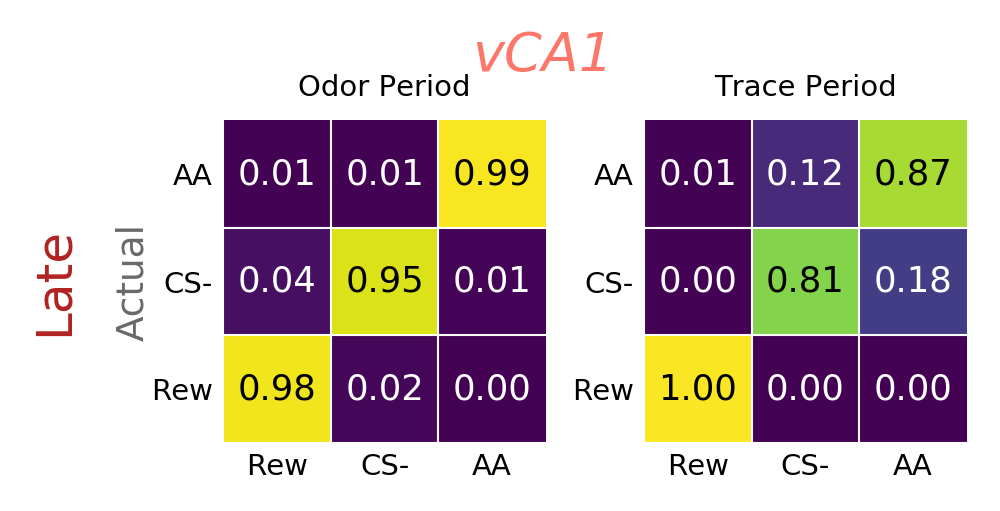

In [87]:
fig, (ax0,ax1) = pl.subplots(1, 2, figsize=(3, 1.5))

for sess,x,c in zip(['post','post'],range(2),[0,2]):
    for i,tb,la in zip(range(2),[3,6],['Odor Period','Trace Period']):
        y = 2*x+i
        im = heatmap(3.*eval("heatmaps_gmins_vhpc_1s_%s[tb]"%sess)/np.sum(eval("heatmaps_gmins_vhpc_1s_%s[tb]"%sess)),(['Rew','CS-','AA']),
                     (['Rew','CS-','AA']), ax=eval('ax%s'%y),vmin=0,vmax=1,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=8.5,textcolors=['white','black'],threshold=.6)
        eval('ax%s'%i).set_title(la)
        for y in 2,3:
            eval("ax%s.set_xlabel"%y)('Predicted',fontsize=9,color='dimgrey',labelpad=1)
        for y in 0,2:
            eval("ax%s.set_ylabel"%y)('Actual',fontsize=9,color='dimgrey',labelpad=0)
ax0.text(-2.3,1,'Late',ha='left',va='center',fontsize=12,color='firebrick',rotation=90)
pl.suptitle('vCA1',fontsize=13,y=1.05,color='#FC766AFF', fontstyle='italic')
pl.tight_layout(h_pad=3)
pl.show()
fig.savefig('../figures/%s_confusion_v.svg'%NOTEBOOK_NAME)

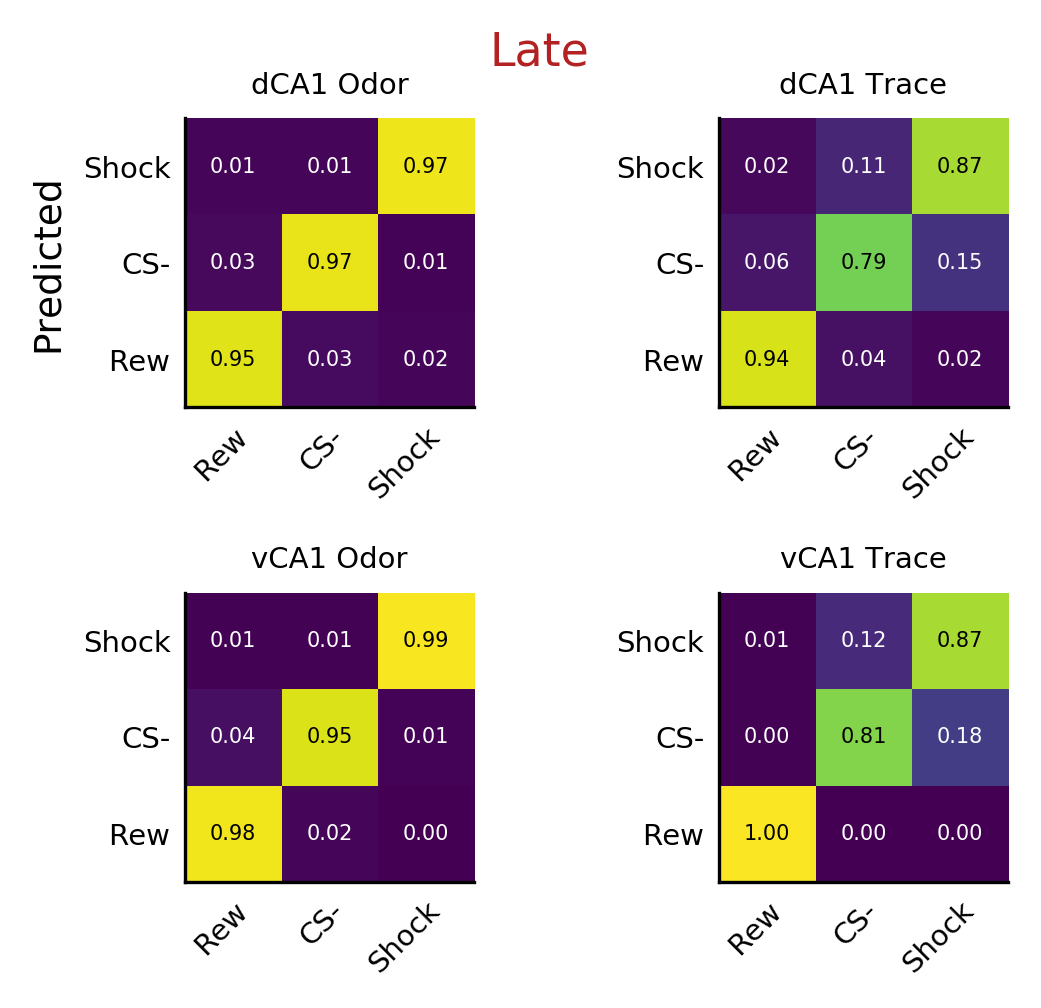

In [70]:
# plot 'em all
sess='post'
fig, ((ax1, ax2),(ax3,ax4)) = pl.subplots(2, 2, figsize=(4, 3.3))

for reg,r,r_la in zip(regions,(0,2),['dCA1','vCA1']):
    for i,j,la in zip([3,6],[1,2],('Odor','Trace')):
        q=j+r
        im = heatmap(eval("3.*heatmaps_gmins_%s_1s_%s[i]/np.sum(heatmaps_gmins_%s_1s_%s[i])"%(reg,sess,reg,sess)),(['Rew','CS-','Shock']),
                     (['Rew','CS-','Shock']), ax=eval('ax%s'%q),vmin=0,vmax=1)
        annotate_heatmap(im, valfmt="{x:.2f}", size=5)
        eval('ax%s'%q).set_title(eval('"%s %s"'%(r_la,la)))
for x in range(7,13):
    eval('ax%s.set_xlabel'%x)('Actual',fontsize=9)
for x in 1,7:
    eval('ax%s.set_ylabel'%x)('Predicted',fontsize=9)
pl.suptitle('Late',color='firebrick',fontsize=11,y=1)
    
pl.tight_layout(pad=2)
pl.show()
fig.savefig('../figures/%s_late_1s.jpg'%NOTEBOOK_NAME)

### only use trials where speed is similar (to control for diff speeds across trial types)

In [38]:
#import speeds and timings of odor onsets
for reg in regions:
    for sess in 'post',:
        for var in ['speed','speed_times','STIMs_ons','is_rewardedt','is_avoidedt','is_CSm_enabledt']:
            try:
                exec("%s_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('%s',\
                                                                   '../%%s/%s/notebooks/autorestore/preprocessing/'%%ani)\
                                                          for ani in %s_%s_animals]))"%(reg,var,sess,reg,sess,var,sess,reg,sess))
            except:
                print 'nope %s %s %s'%(reg,var,sess),

In [39]:
#get mean running speed for ~1s trace period prior to spout moving in
min_avg_speed = 7
max_avg_speed = 12
for reg in regions:
    for sess in 'post',:
        #try:
            exec("mean_trace_speed_%s_%s={}"%(reg,sess))
            exec("is_mean_speedt_%s_%s={}"%(reg,sess))
            for ani in eval("%s_speed_%s.keys()"%(reg,sess)):
                exec("mean_trace_speed_%s_%s[ani]=[]"%(reg,sess))
                exec("is_mean_speedt_%s_%s[ani]=[]"%(reg,sess))
                for i, stim_ons in enumerate(eval("%s_STIMs_ons_%s[ani]"%(reg,sess))):
                    #only get data points during trace period before spout moved in
                    exec("speed_filt = ((%s_speed_times_%s[ani]-stim_ons)>2.5) * ((%s_speed_times_%s[ani]-stim_ons)<=3.5)"%(reg,sess,reg,sess))
                    exec("mean = np.mean(np.r_[%s_speed_%s[ani]][speed_filt])"%(reg,sess))
                    eval("mean_trace_speed_%s_%s[ani].append(mean)"%(reg,sess))
                for x in eval("mean_trace_speed_%s_%s[ani]"%(reg,sess)):
                    eval("is_mean_speedt_%s_%s[ani].append(min_avg_speed <= x <= max_avg_speed)"%(reg,sess))
        #except:
        #    print 'NOPE %s' %sess

In [40]:
def combine_train_test_patterns_num_trials_speed(patterns, labels, num_trials, speed, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    patterns_t={}
    patterns_T={}
    labels_t={}
    labels_T={}
    not_run=[]
    speed_patterns={}
    speed_labels={}
    tot_trials=0
    for ani in patterns.keys():
        #only keep trials where running avg is within window defined earlier
        speed_patterns[ani]=patterns[ani][speed[ani]]
        speed_labels[ani]=labels[ani][speed[ani]]
        #only analyze if have > 5 trials of each trial type
        if (sum(speed_labels[ani]==classes[0])>=3) and (sum(speed_labels[ani]==classes[1])>=3) and (sum(speed_labels[ani]==classes[2])>=3): #only include animal if it has x trials of specified trial type
            which_trains = []
            which_tests = []
            #find min number of trials of both trial types, then downsample the type with more trials to match min
            #need here to ensure you get the same# of trials for each type in the case where min# of trials for either is < num_trials
            min_trials1=np.sum(speed_labels[ani]==classes[0])
            min_trials2=np.sum(speed_labels[ani]==classes[1])
            min_trials3=np.sum(speed_labels[ani]==classes[2])
            min_trials=min(min_trials1,min_trials2,min_trials3)  
            if min_trials < num_trials:
                print ani,"trials:",min_trials,"     ",
            tot_trials = tot_trials + min(min_trials,num_trials)
            for l in classes:
                if l>=0:
                    wt = np.random.permutation(np.where(speed_labels[ani]==l)[0])[:min_trials]
                    # constrain number of trials to be consistent across conditions
                    wt = wt[:num_trials]
                    if train_test_split<1: #split trials into train and test subsets (ratio set by "train_test_split" value)
                        wT = wt[:int(len(wt)*train_test_split)]
                        which_trains.append(wt[int(len(wt)*train_test_split):])
                        which_tests.append(wT)
                    else:
                        which_trains.append(wt)
            which_train[ani] = np.concatenate(which_trains)
            if train_test_split<1:
                which_test[ani] = np.concatenate(which_tests)
        else:
            not_run.append(ani)
    #find total number of trials used across all animals
    
    for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
        patterns_t[ani] = speed_patterns[ani][which_train[ani]]
        labels_t[ani] = speed_labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = combine_patterns(patterns_t, labels_t, classes=classes)

        
    if train_test_split<1:
        for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
            patterns_T[ani] = speed_patterns[ani][which_test[ani]]
            labels_T[ani] = speed_labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
        
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0],not_run,which_cells,tot_trials)
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None,not_run,which_cells,tot_trials)
    
def do_test_within_num_trials_speed(patterns, labels, num_trials, speed, **args):
    x, y, xT, yT,not_run,which_cells,tot_trials = combine_train_test_patterns_num_trials_speed(patterns, labels, num_trials, speed, **args)
    decoder.fit(x, y)
    #print "Not run:",not_run
    return decoder.score(xT, yT)

def Not_Run_speed(patterns, labels, num_trials, speed, **args):
    x, y, xT, yT,not_run,which_cells,tot_trials = combine_train_test_patterns_num_trials_speed(patterns, labels, num_trials, speed,**args)
    return not_run,len(which_cells),tot_trials

def do_predict_within_num_trials_speed(patterns, labels, num_trials,speed, **args):
    x, y, xT, test_labels,not_run,which_cells,tot_trials = combine_train_test_patterns_num_trials_speed(patterns, labels,num_trials, speed, **args)
    decoder.fit(x, y)
    return decoder.predict(xT), test_labels

In [41]:
%%time
n_trials=10
#for time bins durations of 0.5 and 1s, predict odor delivered for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for sess in 'post',:
        print reg,sess
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            #try:
                for t in range(bin_ranges[i]): # number of time bins
                    print t,
                    for n in range(loops):
                        exec("predictions_gmins_speed_%s_%s_%s_%s_%s, labels_gmins_speed_%s_%s_%s = do_predict_within_num_trials_speed(patterns_%s_%s_%s_%s,\
                            labels_%s_%s,num_trials=n_trials,speed=is_mean_speedt_%s_%s,classes=range(5,8),n_cells=340)"%(reg,tb,
                                                                            sess,t,n,reg,sess,n,reg,tb,sess,t,reg,sess,reg,sess))
            #except:
            #    print 'NOPE',
        try:
            exec("not_run_speed_%s_%s,total_cells_speed_%s_%s,tot_trials_speed_%s_%s = Not_Run_speed(patterns_%s_%s_%s_%s,labels_%s_%s,\
                            num_trials=n_trials,speed=is_mean_speedt_%s_%s,classes=range(5,8), n_cells=235)"%(reg,sess,
                                                                    reg,sess,reg,sess,reg,tb,sess,t,reg,sess,reg,sess))
            print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",eval("not_run_speed_%s_%s"%(reg,sess))
            print "total cells =",eval("total_cells_speed_%s_%s"%(reg,sess))
        except:
            print "\nNO ANIMALS MET CRITERIA (all had too few trials)"
        print "Total Trials = ",eval("tot_trials_speed_%s_%s"%(reg,sess)),"\n\n"

computing loop: dhpc post
0 dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc39 trials: 4       dNAc3 trials: 9       dhpc3

In [42]:
#append all loops
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                exec("predictions_gmins_speed_%s_%s_%s_%s_appended = np.append(predictions_gmins_speed_%s_%s_%s_%s_0,predictions_gmins_speed_%s_%s_%s_%s_1)"%(reg,
                                                                                        tb,sess,t,reg,tb,sess,t,reg,tb,sess,t))
                exec("test_labels_gmins_speed_%s_%s_appended = np.append(labels_gmins_speed_%s_%s_0,labels_gmins_speed_%s_%s_1)"%(reg,sess,reg,sess,reg,sess))
                for n in range(2,loops):
                    exec("predictions_gmins_speed_%s_%s_%s_%s_appended = np.append(predictions_gmins_speed_%s_%s_%s_%s_appended,predictions_gmins_speed_%s_%s_%s_%s_%s)"%(reg,
                                                                                        tb,sess,t,reg,tb,sess,t,reg,tb,sess,t,n))
                    exec("test_labels_gmins_speed_%s_%s_appended = np.append(test_labels_gmins_speed_%s_%s_appended,labels_gmins_speed_%s_%s_%s)"%(reg,sess,reg,sess,reg,sess,n))

In [43]:
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                exec('conf_matr_gmins_speed_%s_%s_%s_%s_appended = confusion_matrix(test_labels_gmins_speed_%s_%s_appended,\
                      predictions_gmins_speed_%s_%s_%s_%s_appended)'%(reg,tb,sess,t,reg,sess,reg,tb,sess,t))

In [44]:
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            exec("heatmaps_gmins_speed_%s_%s_%s = []")%(reg,tb,sess)
            for t in range(bin_ranges[i]): # number of time bins
                exec("heatmaps_gmins_speed_%s_%s_%s.append(conf_matr_gmins_speed_%s_%s_%s_%s_appended)"%(reg,tb,sess,reg,tb,sess,t))


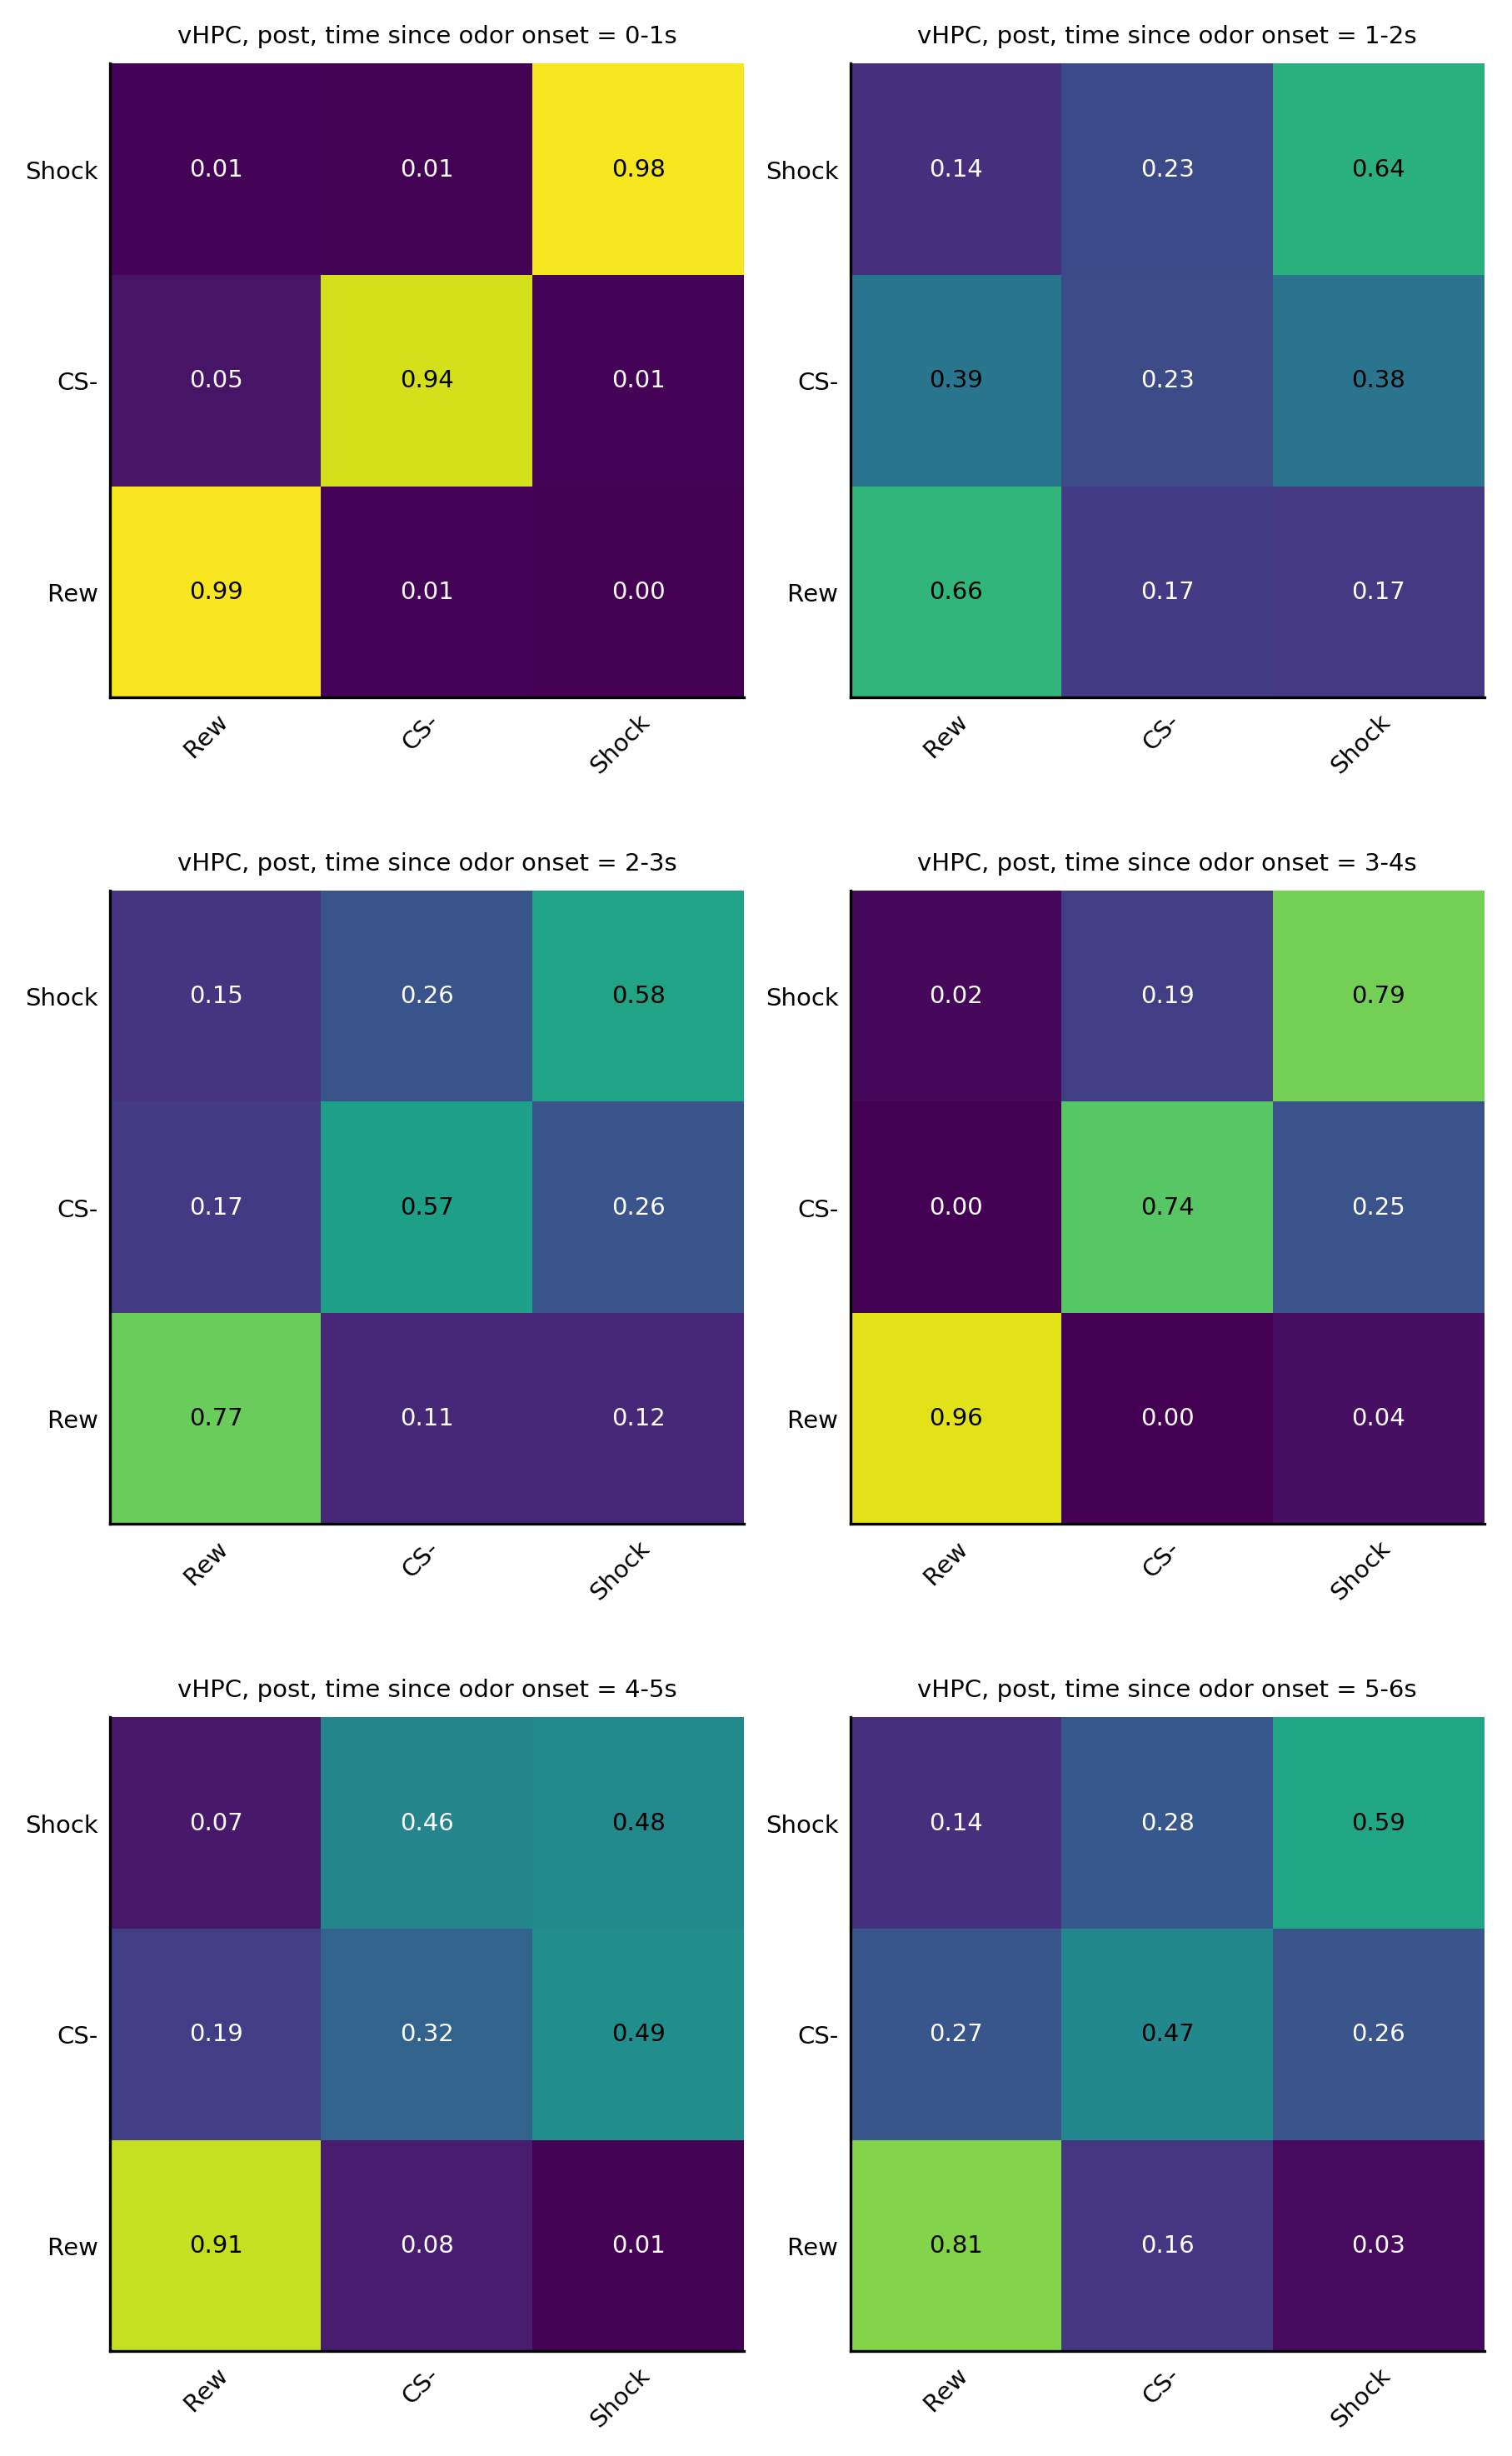

In [45]:
# plot 'em all

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = pl.subplots(3, 2, figsize=(6, 10))

for i,a in zip(range(3,9),range(6)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(3.*heatmaps_gmins_speed_vhpc_1s_post[i]/np.sum(heatmaps_gmins_speed_vhpc_1s_post[i]),(['Rew','CS-', 'Shock']),
                 (['Rew','CS-', 'Shock']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"vHPC, post, time since odor onset = %s-%ss"'%(str(i-3),str(i-2))))

pl.tight_layout()
pl.show()
#fig.savefig('../img/%s_vhpc_pre_ALL.jpg'%NOTEBOOK_NAME)

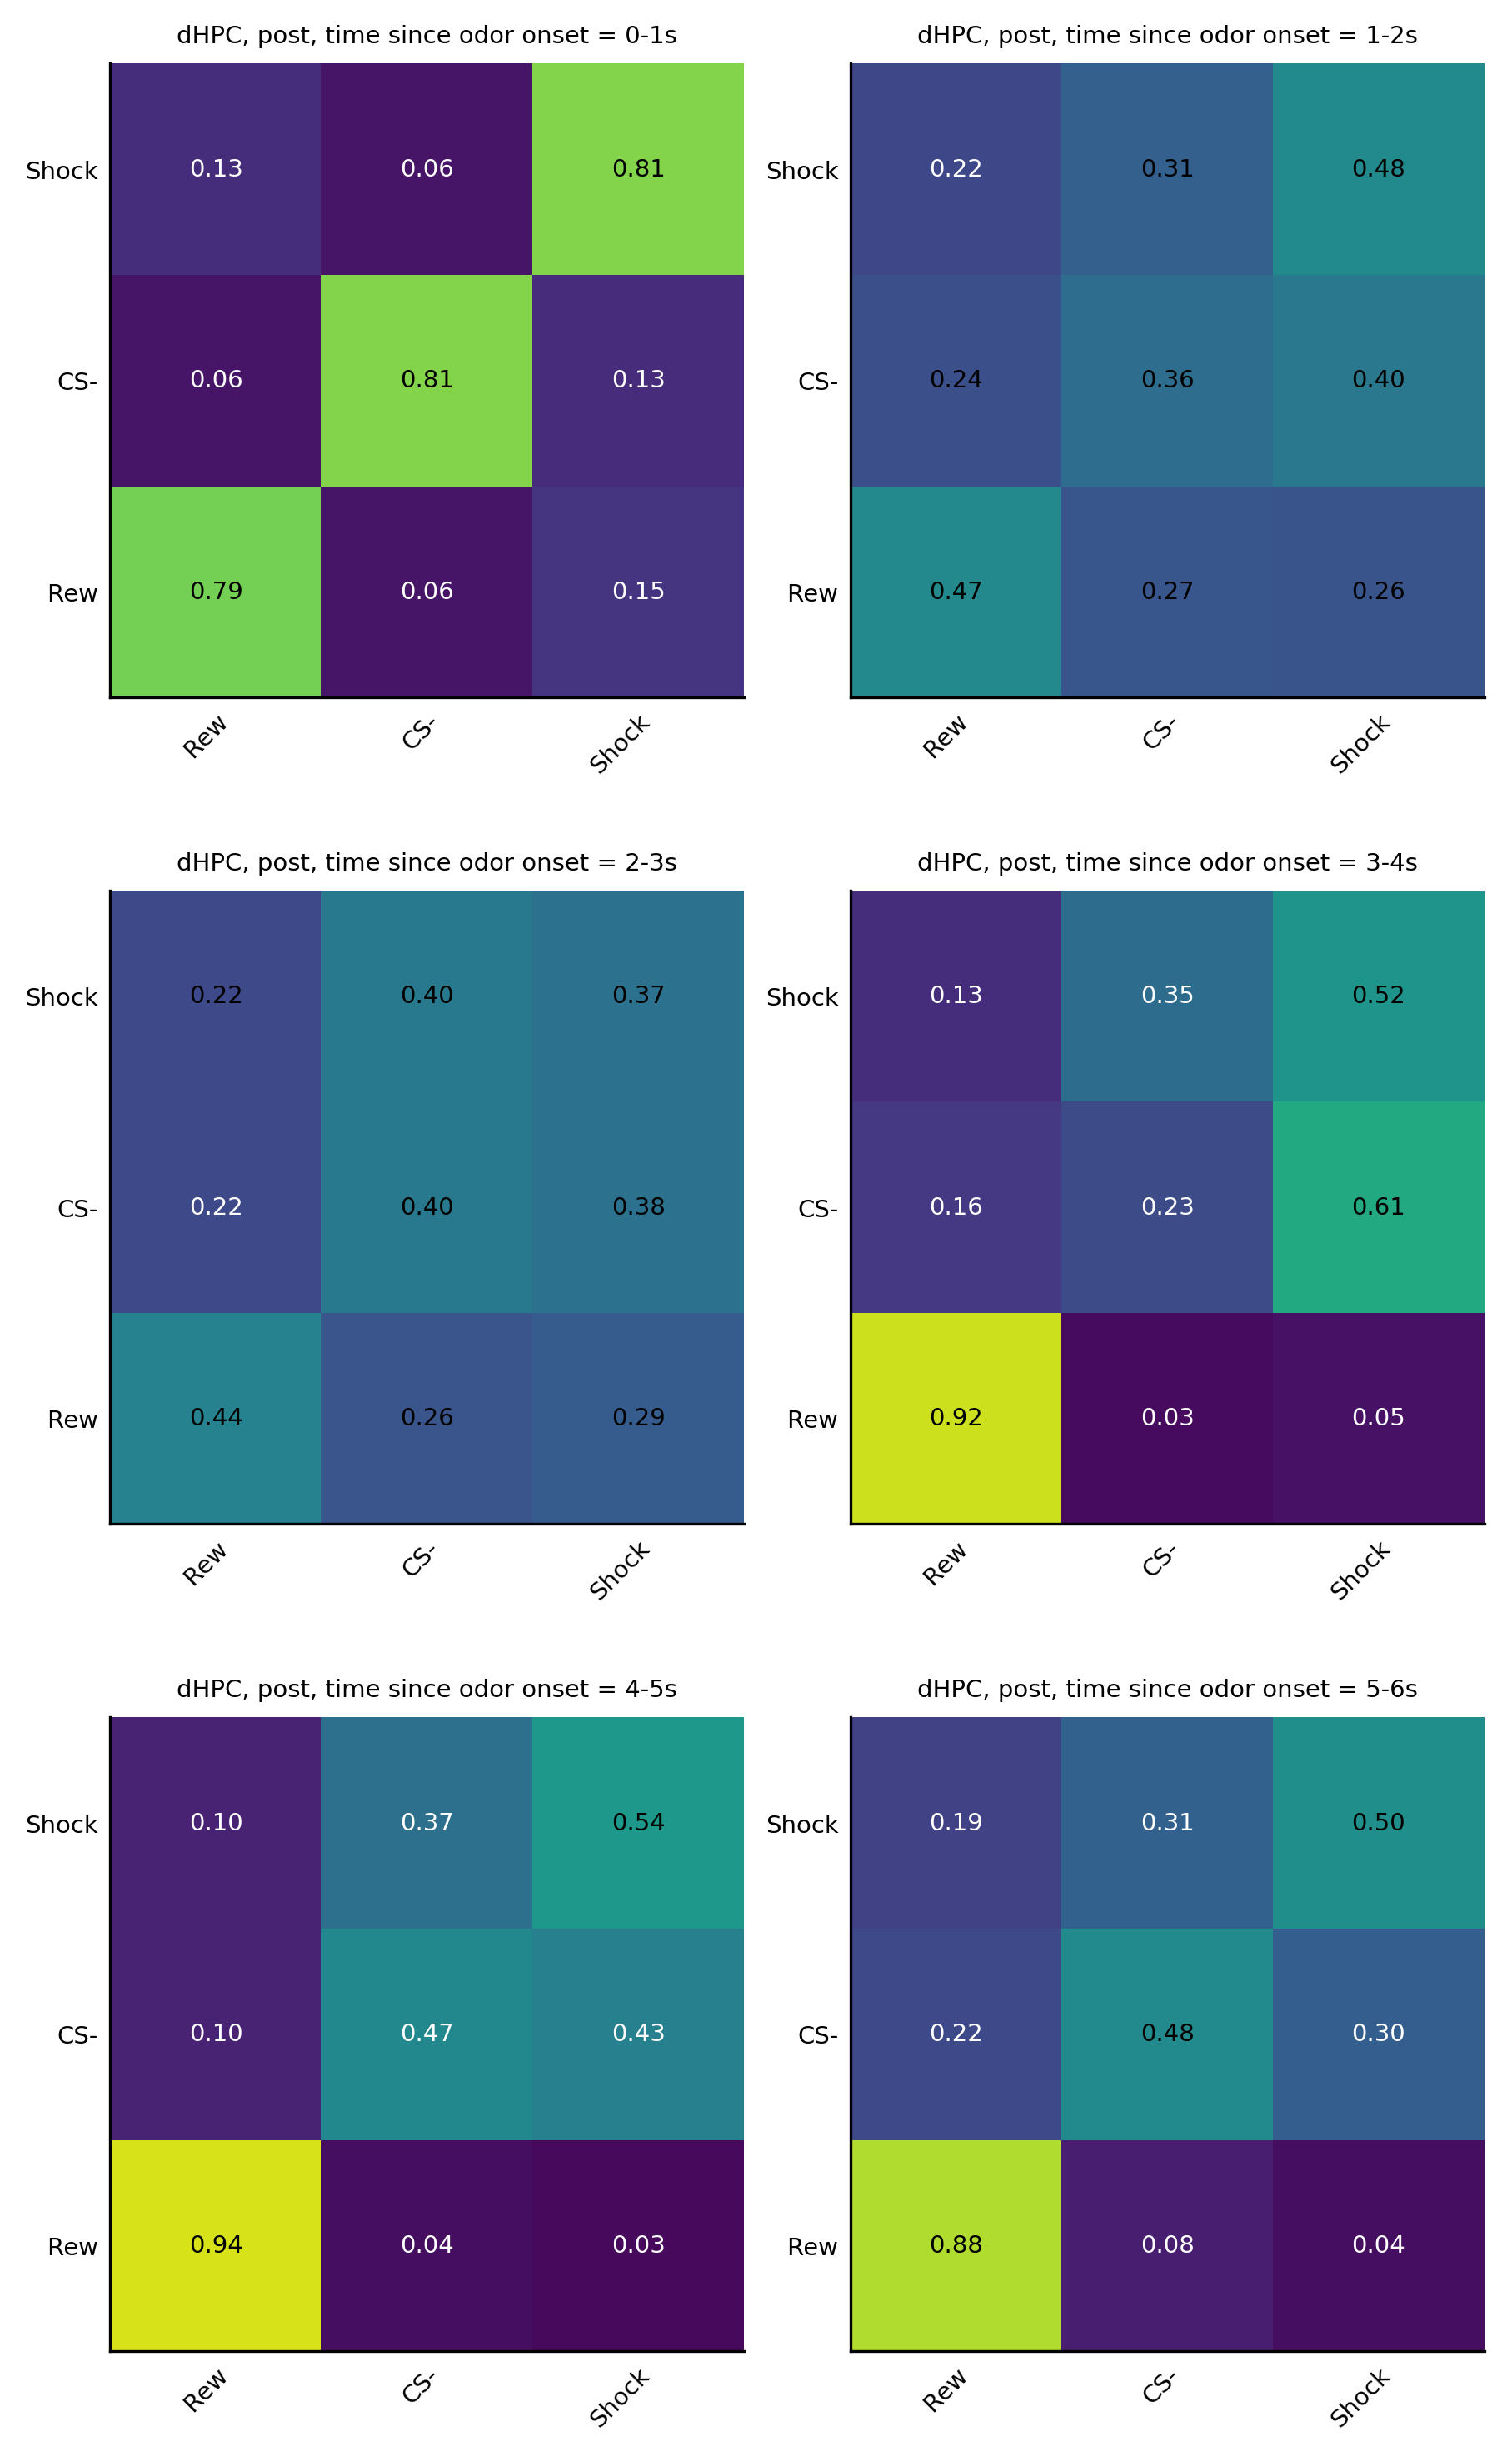

In [46]:
# plot 'em all

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = pl.subplots(3, 2, figsize=(6, 10))

for i,a in zip(range(3,9),range(6)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(3.*heatmaps_gmins_speed_dhpc_1s_post[i]/np.sum(heatmaps_gmins_speed_dhpc_1s_post[i]),(['Rew','CS-', 'Shock']),
                 (['Rew','CS-', 'Shock']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"dHPC, post, time since odor onset = %s-%ss"'%(str(i-3),str(i-2))))

pl.tight_layout()
pl.show()
#fig.savefig('../img/%s_vhpc_pre_ALL.jpg'%NOTEBOOK_NAME)

## now look at "high performing" animals only (got >=20 rewards and avoided majority of shocks)

In [47]:
for reg in regions:
    for tb in bins:
        for sess in sessions:
            try:
                exec("HP_patterns_%s_%s_%s = dict(zip(%s_%s_high_performing_animals, [ut.load_variable('patterns_evs_%s_%s',\
                                                                   '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                          for ani in %s_%s_high_performing_animals]))"%(reg,tb,sess,reg,sess,tb,sess,reg,sess))

                exec("HP_labels_%s_%s = dict(zip(%s_%s_high_performing_animals, [ut.load_variable('labels_%s',\
                                    '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                    for ani in %s_%s_high_performing_animals]))"%(reg,sess, reg,sess, sess, reg,sess))
            except:
                print 'nope %s %s %s   '%(reg,tb,sess),

nope dhpc 05s expo    nope dhpc 05s pre    nope dhpc 05s mid    nope dhpc 1s expo    nope dhpc 1s pre    nope dhpc 1s mid    nope dhpc 15s expo    nope dhpc 15s pre    nope dhpc 15s mid    nope dhpc 2s expo    nope dhpc 2s pre    nope dhpc 2s mid    nope vhpc 05s expo    nope vhpc 05s pre    nope vhpc 05s mid    nope vhpc 1s expo    nope vhpc 1s pre    nope vhpc 1s mid    nope vhpc 15s expo    nope vhpc 15s pre    nope vhpc 15s mid    nope vhpc 2s expo    nope vhpc 2s pre    nope vhpc 2s mid   


In [48]:
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins,range(len(bins))):
            for t in range(bin_ranges[i]):
                exec('HP_patterns_%s_%s_%s_%s = {}'%(reg,tb,sess,t))
                for ani in eval('%s_%s_high_performing_animals'%(reg,sess)):
                    try:
                        #print sess, tb, ani,
                        exec("HP_patterns_%s_%s_%s_%s['%s'] = HP_patterns_%s_%s_%s['%s'][%s]"%(reg,tb,sess,t,ani,reg,tb,sess,ani,t))
                    except:
                        print 'NOPE',reg,sess, tb, ani
                        continue

In [49]:
%%time
n_trials=25
#for time bins durations of 0.5 and 1s, predict odor delivered for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for sess in 'post',:
        print reg,sess
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            #try:
                for t in range(bin_ranges[i]): # number of time bins
                    print t,
                    for n in range(loops):
                        exec("HP_predictions_gmins_%s_%s_%s_%s_%s, HP_test_labels_gmins_%s_%s_%s = do_predict_within_num_trials(HP_patterns_%s_%s_%s_%s,\
                            HP_labels_%s_%s,num_trials=15,classes=range(5,8),n_cells=260)"%(reg,tb,sess,t,n,reg,sess,n,reg,tb,sess,t,reg,sess))
            #except:
            #    print 'NOPE',
        try:
            exec("HP_not_run_%s_%s,HP_total_cells_%s_%s,HP_tot_trials_%s_%s = Not_Run(HP_patterns_%s_%s_%s_%s,HP_labels_%s_%s,\
                            num_trials=n_trials,classes=range(5,8), n_cells=260)"%(reg,sess,
                                                                    reg,sess,reg,sess,reg,tb,sess,t,reg,sess))
            print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",eval("HP_not_run_%s_%s"%(reg,sess))
            print "total cells =",eval("HP_total_cells_%s_%s"%(reg,sess))
        except:
            print "\nNO ANIMALS MET CRITERIA (all had too few trials)"
        print "Total Trials = ",eval("HP_tot_trials_%s_%s"%(reg,sess)),"\n\n"

computing loop: dhpc post
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 0 1 2 3 4 5 6 7 8 9 10 11 12 13 

NOT INCLUDED IN ANALYSIS (too few trials): []
total cells = 260
Total Trials =  75 


vhpc post
0 99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 trials: 14       99b trials: 8       99 tr

In [50]:
#append all loops
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                exec("HP_predictions_gmins_%s_%s_%s_%s_appended = np.append(HP_predictions_gmins_%s_%s_%s_%s_0,HP_predictions_gmins_%s_%s_%s_%s_1)"%(reg,
                                                                                        tb,sess,t,reg,tb,sess,t,reg,tb,sess,t))
                exec("HP_test_labels_gmins_%s_%s_appended = np.append(HP_test_labels_gmins_%s_%s_0,HP_test_labels_gmins_%s_%s_1)"%(reg,sess,reg,sess,reg,sess))
                for n in range(2,loops):
                    exec("HP_predictions_gmins_%s_%s_%s_%s_appended = np.append(HP_predictions_gmins_%s_%s_%s_%s_appended,HP_predictions_gmins_%s_%s_%s_%s_%s)"%(reg,
                                                                                        tb,sess,t,reg,tb,sess,t,reg,tb,sess,t,n))
                    exec("HP_test_labels_gmins_%s_%s_appended = np.append(HP_test_labels_gmins_%s_%s_appended,HP_test_labels_gmins_%s_%s_%s)"%(reg,sess,reg,sess,reg,sess,n))

In [51]:
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                exec('HP_conf_matr_gmins_%s_%s_%s_%s_appended = confusion_matrix(HP_test_labels_gmins_%s_%s_appended,\
                      HP_predictions_gmins_%s_%s_%s_%s_appended)'%(reg,tb,sess,t,reg,sess,reg,tb,sess,t))

In [52]:
for reg in regions:
    for sess in 'post',:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            exec("HP_heatmaps_gmins_%s_%s_%s = []")%(reg,tb,sess)
            for t in range(bin_ranges[i]): # number of time bins
                exec("HP_heatmaps_gmins_%s_%s_%s.append(HP_conf_matr_gmins_%s_%s_%s_%s_appended)"%(reg,tb,sess,reg,tb,sess,t))


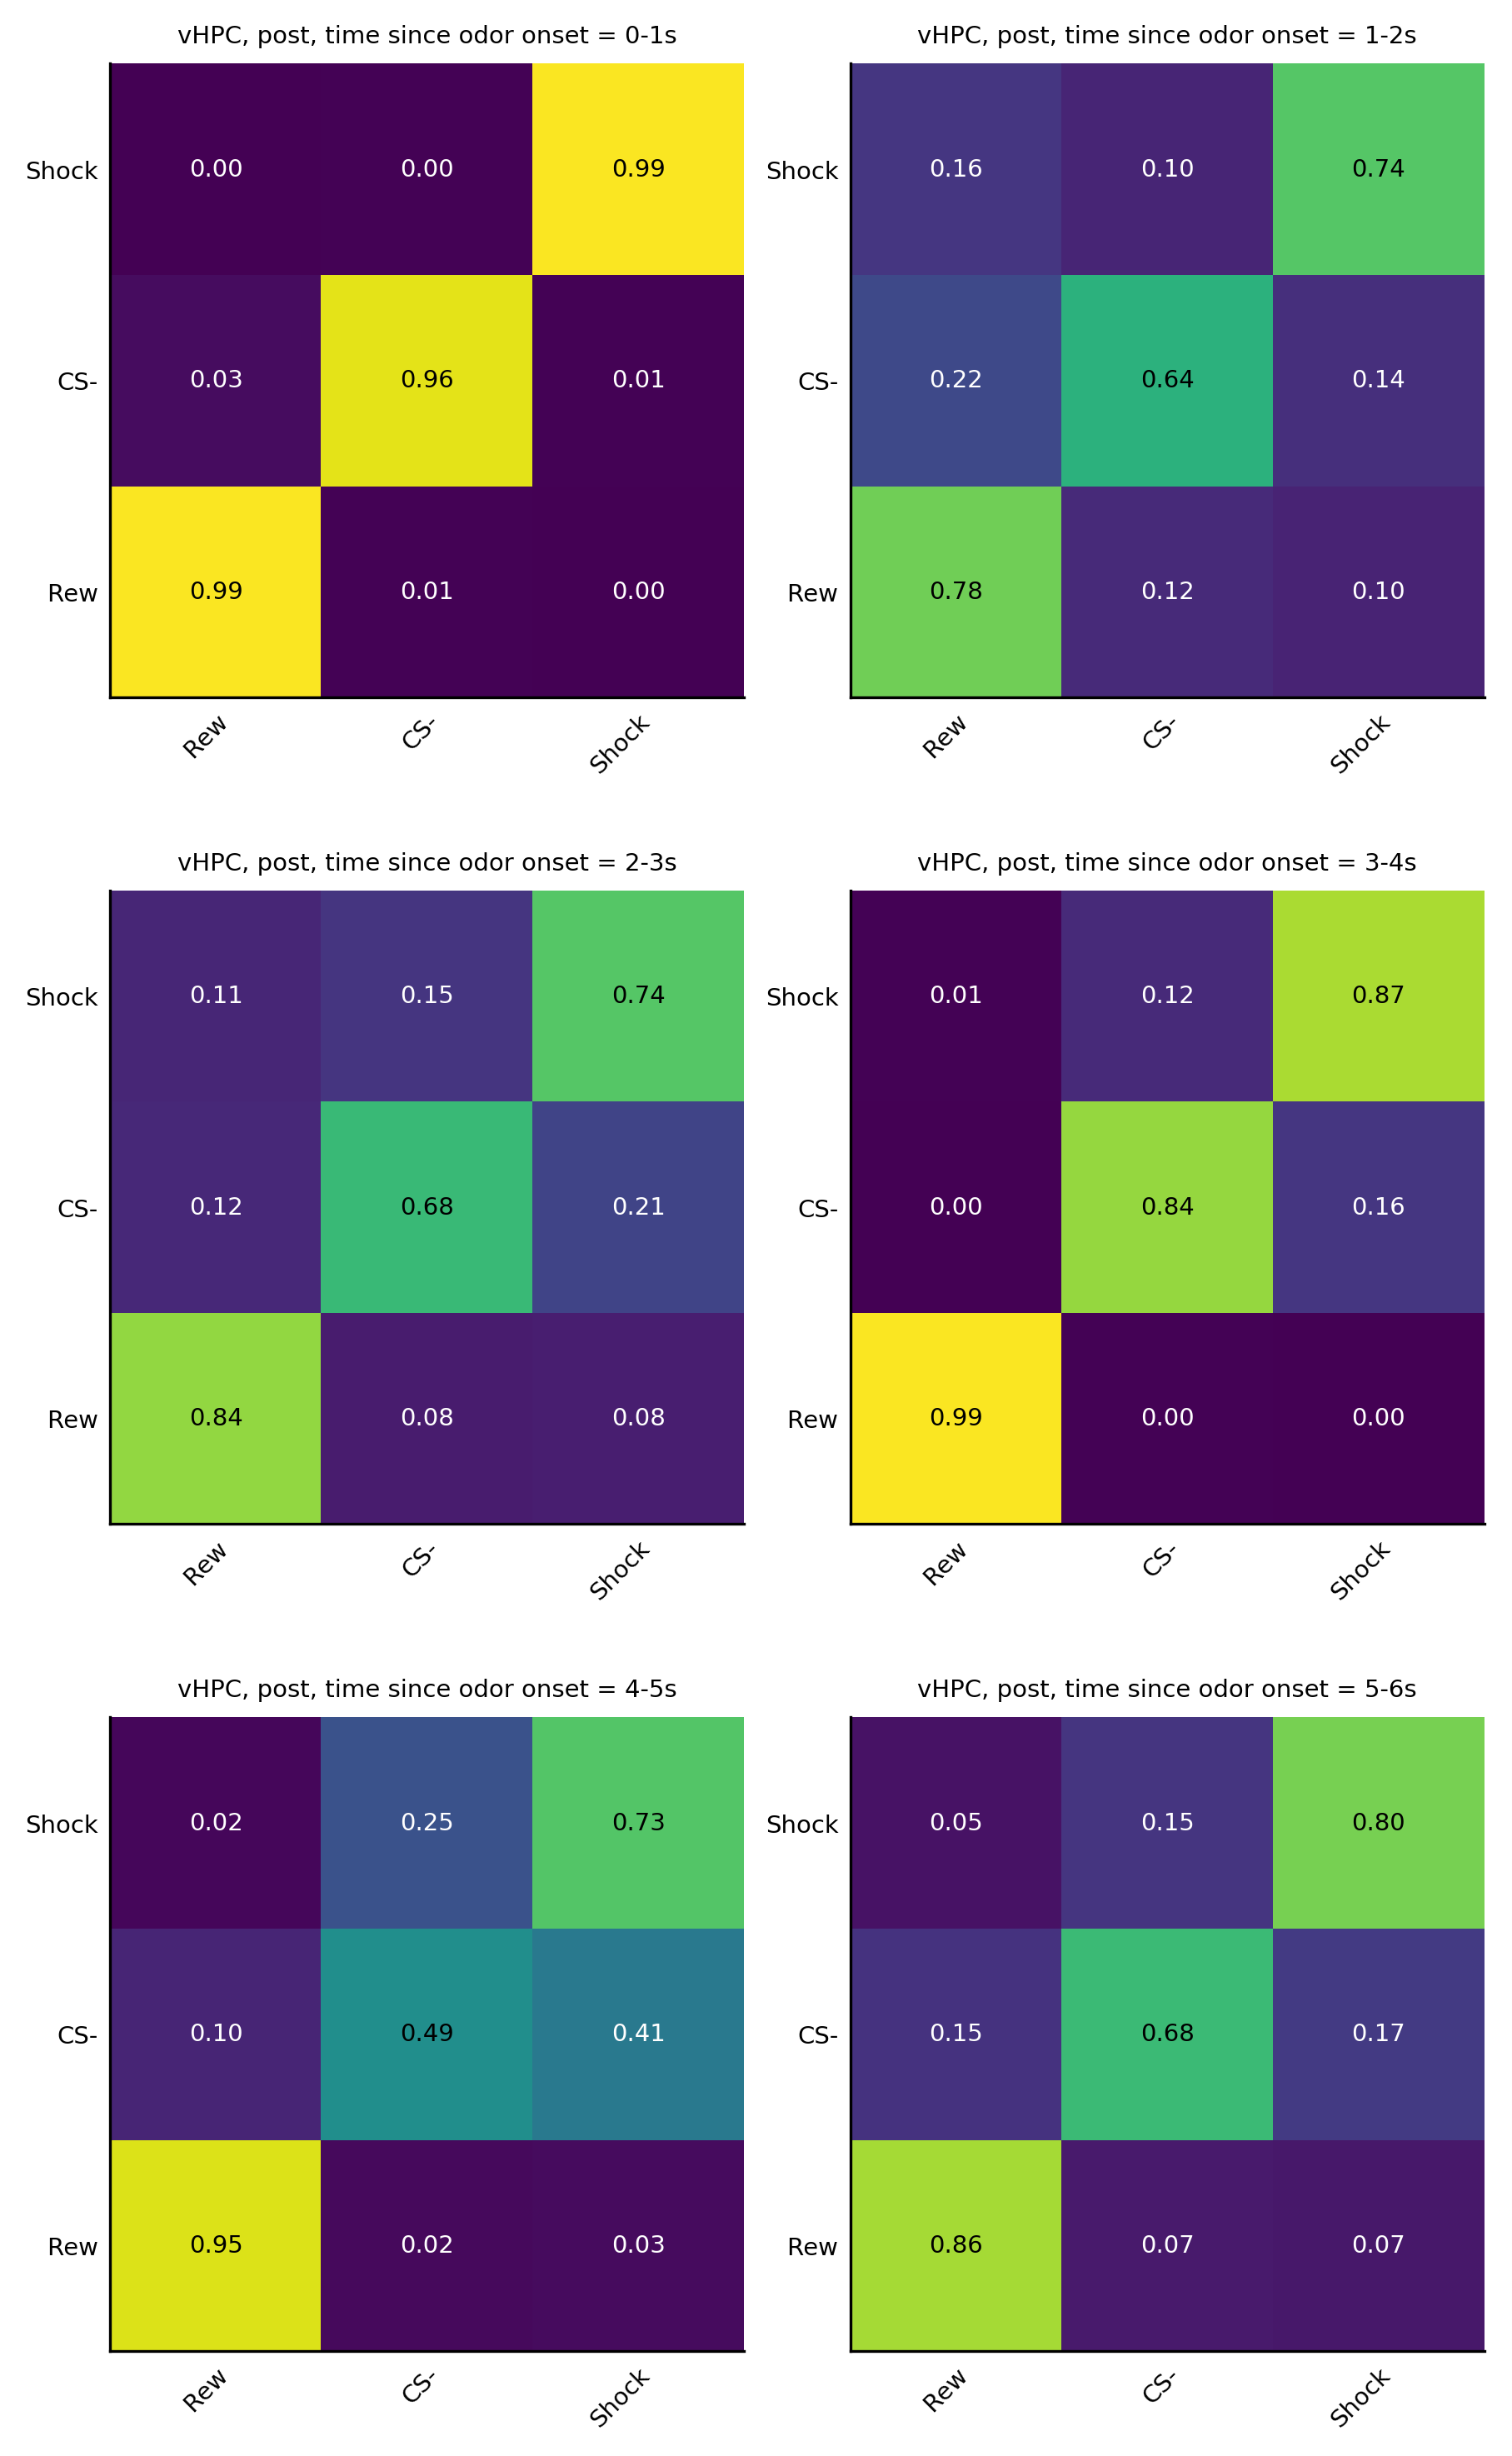

In [53]:
# plot 'em all

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = pl.subplots(3, 2, figsize=(6, 10))

for i,a in zip(range(3,9),range(6)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(3.*HP_heatmaps_gmins_vhpc_1s_post[i]/np.sum(HP_heatmaps_gmins_vhpc_1s_post[i]),(['Rew','CS-', 'Shock']),
                 (['Rew','CS-', 'Shock']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"vHPC, post, time since odor onset = %s-%ss"'%(str(i-3),str(i-2))))

pl.tight_layout()
pl.show()
#fig.savefig('../img/%s_vhpc_pre_ALL.jpg'%NOTEBOOK_NAME)

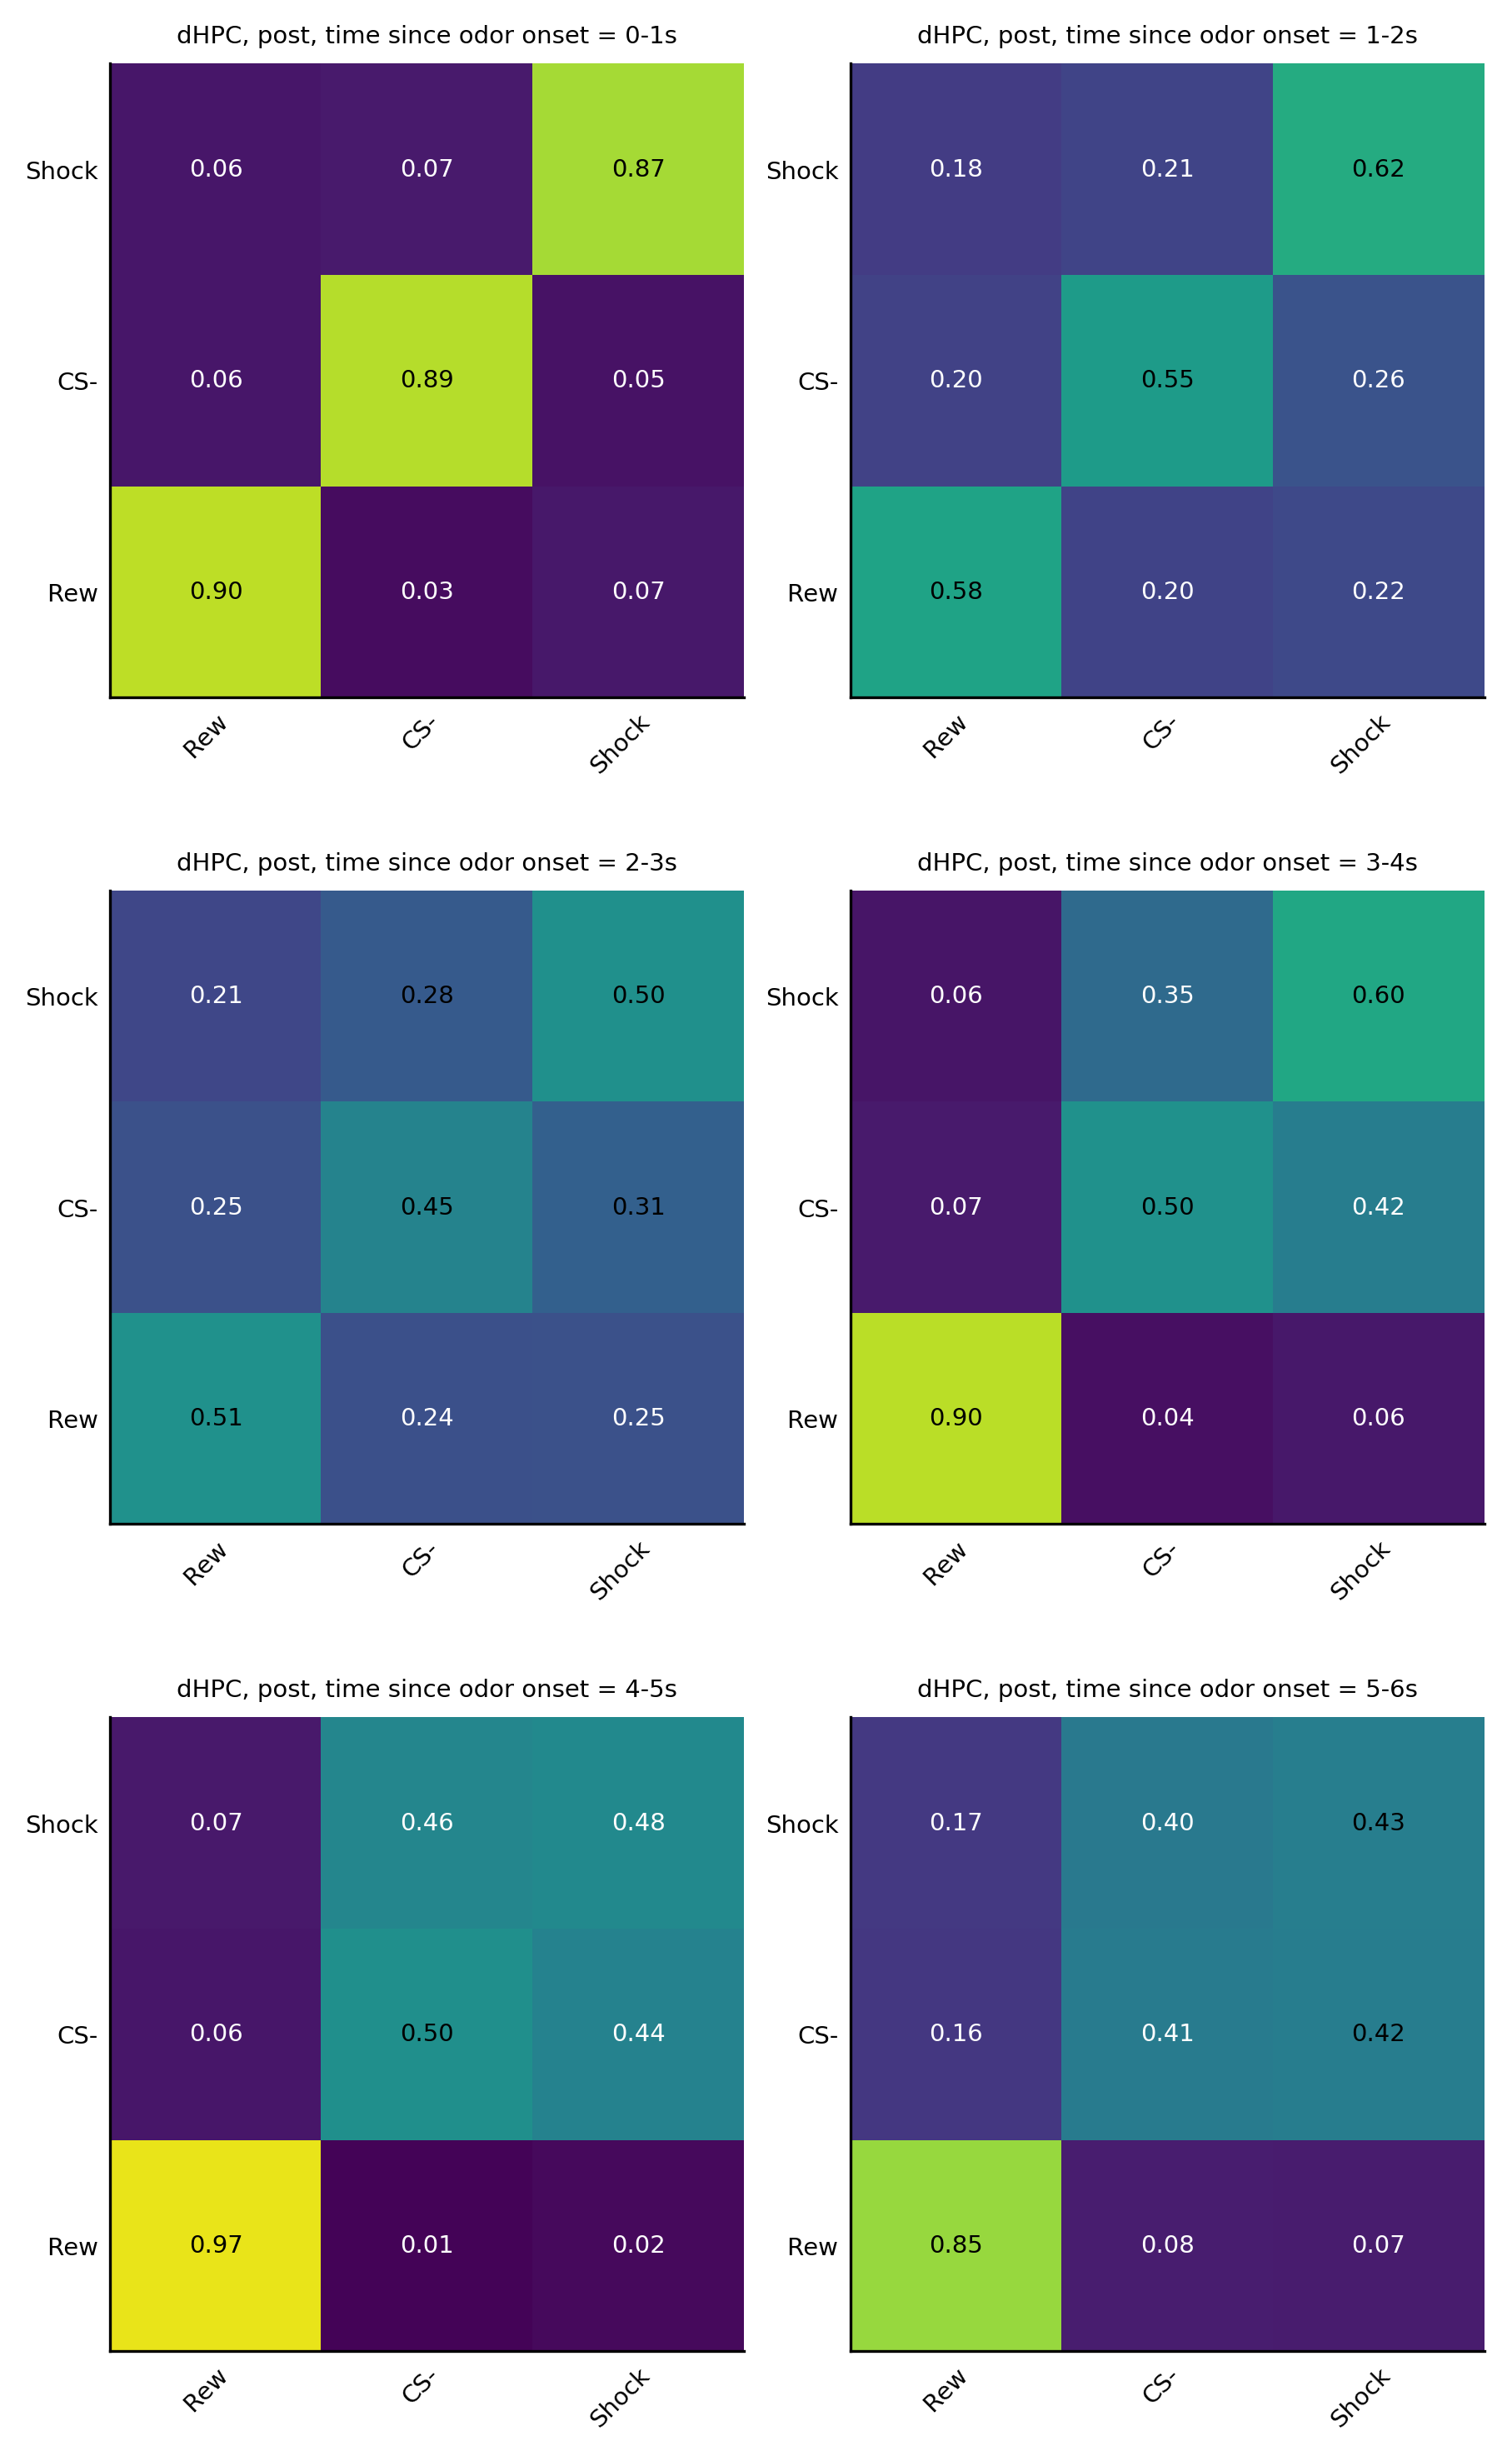

In [54]:
# plot 'em all

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = pl.subplots(3, 2, figsize=(6, 10))

for i,a in zip(range(3,9),range(6)): #look at six consecutive 1s bins, beginning at odor onset
    im = heatmap(3.*HP_heatmaps_gmins_dhpc_1s_post[i]/np.sum(HP_heatmaps_gmins_dhpc_1s_post[i]),(['Rew','CS-', 'Shock']),
                 (['Rew','CS-', 'Shock']), ax=eval('ax%s'%a),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%a).set_title(eval('"dHPC, post, time since odor onset = %s-%ss"'%(str(i-3),str(i-2))))

pl.tight_layout()
pl.show()
#fig.savefig('../img/%s_vhpc_pre_ALL.jpg'%NOTEBOOK_NAME)

In [55]:
save_workspace(db)

Could not store variable 'pickle'. Skipping...
Could not store variable 'matplotlib'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'h5py'. Skipping...
